# Running RAMP OpenCL model with dynamic calibration

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The current risk beta parameter is calibrated in [this notebook](http://localhost:8888/notebooks/Users/gy17m2a/OneDrive%20-%20University%20of%20Leeds/Project/RAMP-UA/experiments/calibration/abc-2-NewObs.ipynb). This involves determining a prior distribution for both the current risk beta parameter, and for the individual and location hazard parameters. Approximate Bayesian Computation (ABC) is then used to approximate the likelihood of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. In this script, the model is ran using ABC for 105 days, with two populations. 

In this notebook, the current risk beta parameter value which was associated with the highest fitness in the final population in the calibration process above is set as a constant, and assumed not to change over the life of the disease. However, as the disease evolves, it is expected that the other parameters pertaining to the hazard associated with individuals and locations will change. If a model is calibrated just once using historical data then it will be unable to account for this parameter evolution. However, if it is dynamically calibrated, then it can be optimised in response to changes in parameter values in real time. Dynamic calibration involves re-calibrating the model at each time-step (e.g. after one day, one week etc), and using the best performing parameter value from the previous time-step for the next time-step. 

### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       

### Import modules

In [1]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True


C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Create observed cases data

In [2]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_shifted_mpld_smoothed_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

# Read in daily msoa case data (interpoalted from weekly)
cases_msoa_daily = pd.read_csv("observation_data/daily_cases_msoas_shifted_mpld_smoothed_IS.csv")
#Create new dataframe with cumulative sums rather than cases per day
#cases_msoa_daily['CumulativeCases'] = cases_msoa_daily['OriginalCases'].cumsum()
# remove date column
cases_msoa_daily = cases_msoa_daily.iloc[:, 1:]
cases_msoa_daily = cases_msoa_daily.T
cases_msoa_daily.columns = range(1,(cases_msoa_daily.shape[1])+1)
cases_msoa_daily = cases_msoa_daily.add_prefix('Day')


#### Setup Model

 Read in parameters

In [3]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).

In [4]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Run model with default parameter values 

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

#### Initialise model

In [173]:
## Define parameters
ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer() # check it is divisible by 7 
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
OpenCLRunner.init( iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR,snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS)

# Set constants
const_params_dict = {"current_risk_beta":0.00555,"home": 1.0} 
OpenCLRunner.set_constants(const_params_dict)

#### Run model

In [174]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness_manualcalibration, sim_manualcalibration, obs_manualcalibration, out_params_manualcalibration, summaries_manualcalibration) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


#### Plot results

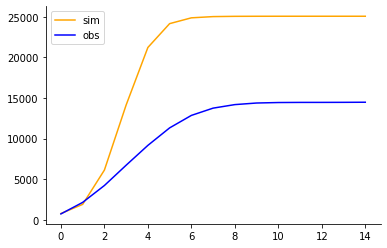

In [175]:
# Check the model returns the observations correctly i.e. that theyre the same length
np.array_equal(obs_manualcalibration, cases_devon_daily.loc[:len(sim_manualcalibration)-1,"CumulativeCases"])

# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_manualcalibration))
ax.plot(x, sim_manualcalibration, label="sim", color="orange")
ax.plot(x, obs_manualcalibration, label="obs", color="blue")
ax.legend()


## Run model with dynamic calibration
### Define parameter values
#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [8]:
const_params_dict = { "current_risk_beta": 0.025239665550846085,"home": 1.0}

#### Define random variables and the prior distributions
Random variables are the global parameters.

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


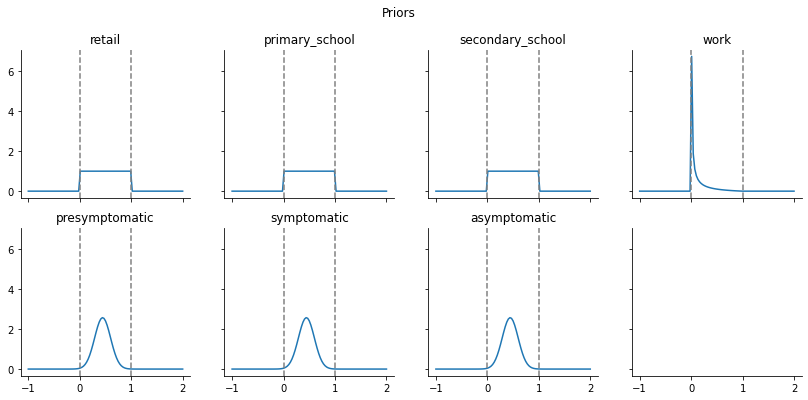

In [9]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

# Plot priors
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Define parameters for running model

In [10]:
# Set the size of a data assimilation window in days:
da_window_size =14

# Initialise the population
DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()
print(f"Activity locations: {activity_locations}")


# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,  "run_length": da_window_size,
                "current_particle_pop_df": None,  "parameters_file": PARAMETERS_FILE, "snapshot_file": SNAPSHOT_FILEPATH, 
                "opencl_dir": OPENCL_DIR, "individuals_df": individuals_df, 
                "observations_weekly_array": observations_weekly_array,'num_seed_days' :7}

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define dynamic calibration loop

In [11]:
# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict, weights_dict, history-dict = {}, {},{}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler())
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        #transition=transition,  # Define how to transition from one population to the next

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(db=db_path,observed_sum_stat=None)  # {'observation': observations_array, "individuals": individuals_df}

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history


Window number:  1
Running for 14 days


ABC.History INFO: Start <ABCSMC id=127, start_time=2022-02-28 13:59:03>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.95888382e+03.
ABC INFO: Accepted: 100 / 224 = 4.4643e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.31888382e+03.


Perturbed parameter <Parameter 'asymptomatic': 0.24832595644685448, 'presymptomatic': 0.7657313172538854, 'primary_school': 0.5708190625388551, 'retail': 0.03775284301657522, 'secondary_school': 0.39342278942336684, 'symptomatic': 0.2746834593379008, 'work': 0.004446770093575989>
Perturbed parameter <Parameter 'asymptomatic': 0.45421314935188445, 'presymptomatic': 0.4734023243779478, 'primary_school': 0.3892629358675772, 'retail': 1.0628041634624068, 'secondary_school': 0.3142723296359099, 'symptomatic': 0.5927407764672263, 'work': 0.018460134282257422>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.37628550129183086, 'presymptomatic': 0.1661049458958972, 'primary_school': 0.13231043087157598, 'retail': 0.07283934491046509, 'secondary_school': 0.5786383607713912, 'symptomatic': 0.44908522277540286, 'work': 0.0005997350344588071>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.4404922909644361, 'presymptomatic': 0.6864279620767989, 'primary

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.17799979431597296, 'presymptomatic': 0.44911301554019123, 'primary_school': 0.28148672251451523, 'retail': 0.08264552141692726, 'secondary_school': 0.8050747787281154, 'symptomatic': 0.2658785715841127, 'work': 0.008450019555017138>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.45383950714079174, 'presymptomatic': 0.3743396012133007, 'primary_school': 0.4513168127275907, 'retail': 0.2817766919220672, 'secondary_school': 0.5794099300055133, 'symptomatic': 0.3461446171354703, 'work': 0.015317950595799145>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.04362266103293766, 'presymptomatic': 0.7178013229274678, 'primary_school': 0.17626983639868593, 'retail': 0.25814212175284823, 'secondary_school': 0.9801499628938042, 'symptomatic': 0.6367578096611988, 'work': 0.00

Perturbed parameter <Parameter 'asymptomatic': 0.2887787402606635, 'presymptomatic': 0.3033841882482185, 'primary_school': 0.5804622775399535, 'retail': 0.5727958421191699, 'secondary_school': 0.4935608116632675, 'symptomatic': 0.3863673678135461, 'work': 0.027760281370643722>
Perturbed parameter <Parameter 'asymptomatic': 0.1938678571408087, 'presymptomatic': 0.3951250366527864, 'primary_school': 1.0885565552169585, 'retail': 0.14699712232470036, 'secondary_school': 0.5352652942050578, 'symptomatic': 0.554895812362709, 'work': 0.0031823910939711014>
Perturbed parameter <Parameter 'asymptomatic': 0.31081461366506963, 'presymptomatic': 0.2281956054387452, 'primary_school': 0.5195427236671438, 'retail': 0.7455702391181911, 'secondary_school': 0.3972397987241013, 'symptomatic': 0.490758089838325, 'work': 0.00504581509349591>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.1733715026007326, 'presymptomatic': 0.5252877870838374, 'primary_school':

Perturbed parameter <Parameter 'asymptomatic': 0.12934837276237626, 'presymptomatic': 0.3703448391103652, 'primary_school': 0.6398946371262275, 'retail': 0.4332495983762993, 'secondary_school': 0.4187257454046056, 'symptomatic': 0.8785525100838588, 'work': 0.009135863648018154>
Perturbed parameter <Parameter 'asymptomatic': 0.1809963648932797, 'presymptomatic': 0.4403621347479908, 'primary_school': 0.53327741168989, 'retail': 0.05721728724473531, 'secondary_school': 0.3596582348034781, 'symptomatic': 0.09084172325527726, 'work': 0.019318564556379744>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.5207459220273112, 'presymptomatic': 0.6259636502475961, 'primary_school': 0.3214135663618155, 'retail': 0.5993481392062786, 'secondary_school': 0.1059834736643412, 'symptomatic': 0.2726002997809811, 'work': 0.0055317260862458445>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed 

Perturbed parameter <Parameter 'asymptomatic': 0.25590639937653187, 'presymptomatic': 0.9122394632256563, 'primary_school': 0.019895455073714655, 'retail': 0.999653933802735, 'secondary_school': 0.08228574621462839, 'symptomatic': 0.843144397284234, 'work': 0.00043258957201875695>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3916353947993041, 'presymptomatic': 0.5211903339713729, 'primary_school': 0.3598923816948078, 'retail': 0.47408934505696876, 'secondary_school': 0.5875364881460132, 'symptomatic': 0.3895010766310762, 'work': 0.004321688008584664>
Perturbed parameter <Parameter 'asymptomatic': 0.3122916383210381, 'presymptomatic': 0.4431403874926828, 'primary_school': 0.4070927026581825, 'retail': 0.23195989638264755, 'secondary_school': 0.993829818552431, 'symptomatic': 0.4582731161983782, 'work': 0.009258767802096007>
Perturbed parameter <Parameter 'asymptomatic': 0.2652473915803277, 'presymptomatic': 0.7031007670785193, 'primary_sch

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.401709628467213, 'presymptomatic': 0.5793866793787749, 'primary_school': 0.23934098983936167, 'retail': 0.9121571873003828, 'secondary_school': 0.7581250338979034, 'symptomatic': 0.5026672966292242, 'work': 0.029513767153996548>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.4337354310608921, 'presymptomatic': 0.2772296010638672, 'primary_school': 0.3390004085630732, 'retail': 0.7371112791804172, 'secondary_school': 0.6147503679500064, 'symptomatic': 0.39809088905496276, 'work': 0.022221543191331603>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.6324438245154277, 'presymptomatic': 0.5103933308977671, 'primary_school': 0.7057050294276963, 'retail': 0.6599098898343441, 'secondary_school': 0.07681652191517718, 'symptomatic': 0.40165784233532154, 'work': 0.011789226415184473>
Negatives

Perturbed parameter <Parameter 'asymptomatic': 0.3724654786776539, 'presymptomatic': 0.1973602692898389, 'primary_school': 0.07158103209659239, 'retail': 0.7149297205613636, 'secondary_school': 0.028947790284726736, 'symptomatic': 0.21707353138800703, 'work': 0.0055263039248808305>
Perturbed parameter <Parameter 'asymptomatic': 0.3688905198677829, 'presymptomatic': 0.09430851332249668, 'primary_school': 0.6694112035924209, 'retail': 0.7465951545311984, 'secondary_school': 1.088149885628467, 'symptomatic': 0.3322121149936723, 'work': 0.00275019183943271>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.39058217538987633, 'presymptomatic': 0.6322374677299301, 'primary_school': 0.19041618061331048, 'retail': 0.3638608577160388, 'secondary_school': 0.2562684216372176, 'symptomatic': 0.4224987778962876, 'work': 0.0004759144713207232>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3823714179485146, 'presymptomatic': 0.549929

Perturbed parameter <Parameter 'asymptomatic': 0.3252434768179009, 'presymptomatic': 0.13486614818790407, 'primary_school': 0.3186939635756479, 'retail': 0.7772808284453031, 'secondary_school': 0.5673605529179039, 'symptomatic': 0.9902871143163953, 'work': 0.006142840722714231>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.20440034272378094, 'presymptomatic': 0.09478178820725816, 'primary_school': 0.05964281979522612, 'retail': 0.136025084894018, 'secondary_school': 0.061252426113051595, 'symptomatic': 0.21956768528548246, 'work': 0.018252746204107405>
Perturbed parameter <Parameter 'asymptomatic': 0.3513914162579373, 'presymptomatic': 0.48146988637283816, 'primary_school': 0.5665173742859816, 'retail': 0.8471563838374938, 'secondary_school': 0.611554997357946, 'symptomatic': 0.4370801356462571, 'work': 0.0003231644267235567>
Perturbed parameter <Parameter 'asymptomatic': 0.4631894302766177, 'presymptomatic': 0.118702

Perturbed parameter <Parameter 'asymptomatic': 0.46432909059836003, 'presymptomatic': 0.6256018698105956, 'primary_school': 0.7018840368893704, 'retail': 0.6451760442522657, 'secondary_school': 0.16634090367240079, 'symptomatic': 0.5417996505356397, 'work': 0.016180676613647357>
Perturbed parameter <Parameter 'asymptomatic': 0.26588094377623006, 'presymptomatic': 0.4043341351353795, 'primary_school': 0.493147985670406, 'retail': 0.23524784617005734, 'secondary_school': 0.2830769459984709, 'symptomatic': 0.38338328451075177, 'work': 0.07543060533699769>


ABC INFO: Accepted: 100 / 189 = 5.2910e-01, ESS: 1.3719e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=127, duration=0:55:24.274877, end_time=2022-02-28 14:54:27>


0
1
Window number:  2
Running for 28 days
init


ABC.History INFO: Start <ABCSMC id=128, start_time=2022-02-28 14:54:28>
ABC INFO: Calibration sample t = -1.


Perturbed parameter <Parameter 'asymptomatic': 0.4796525044115765, 'presymptomatic': 0.3490884763876474, 'primary_school': 0.7201095050549384, 'retail': 0.40265893857841445, 'secondary_school': 0.13083161183929098, 'symptomatic': 0.09272999564157883, 'work': 0.0013118158497588714>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.265681589783526, 'presymptomatic': 0.2829946907086462, 'primary_school': 0.27945854611050636, 'retail': 0.057035409170619916, 'secondary_school': 0.7602374768978782, 'symptomatic': 0.6249921512900318, 'work': 0.023354114636778864>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3728703425793449, 'presymptomatic': 0.32282567320169264, 'primary_school': 0.5357447740825684, 'retail': 0.9088973873208271, 'secondary_school': 0.6342377109674167, 'symptomatic': 0.48911544989008343, 'work': 0.018382272827060307>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0

Perturbed parameter <Parameter 'asymptomatic': 0.2898215321147087, 'presymptomatic': 0.4888621273178926, 'primary_school': 0.6589552018124439, 'retail': 0.3976044672699387, 'secondary_school': 0.05628091288287901, 'symptomatic': 0.40879261239647513, 'work': 0.07495703366594489>
Perturbed parameter <Parameter 'asymptomatic': 0.34249900836583513, 'presymptomatic': 0.36786085265187446, 'primary_school': 0.5544913985724088, 'retail': 0.3394796420649967, 'secondary_school': 0.3960171204257398, 'symptomatic': 0.383641101430531, 'work': 0.00631622852184551>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.39196535403226607, 'presymptomatic': 0.3256068208646281, 'primary_school': 0.43806029564507853, 'retail': 0.587316018466757, 'secondary_school': 0.1969323210870464, 'symptomatic': 0.05793722146808307, 'work': 0.0289395

Perturbed parameter <Parameter 'asymptomatic': 0.39306704561365874, 'presymptomatic': 0.41917353866448986, 'primary_school': 1.059444363655567, 'retail': 0.45397549819542177, 'secondary_school': 0.3900040292121787, 'symptomatic': 0.30573251144704894, 'work': 0.009049603201236501>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.15234486250973778, 'presymptomatic': 0.6794844283097135, 'primary_school': 0.8077501595036621, 'retail': 0.36153337318261947, 'secondary_school': 0.23179223143239208, 'symptomatic': 0.6608480778135958, 'work': 0.024859275412943502>
Perturbed parameter <Parameter 'asymptomatic': 0.2681805515769598, 'presymptomatic': 0.19809038063897438, 'primary_school': 0.1301203148031302, 'retail': 0.04858976564140649, 'secondary_school': 0.6957783684464232, 'symptomatic': 0.29203730520308446, 'work': 0.03944151320019409>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.40196459126029066, 'presymptomatic': 0.4111

Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.48530804013402573, 'presymptomatic': 0.1673176536600776, 'primary_school': 0.49974367451233875, 'retail': 0.2936161600630657, 'secondary_school': 0.32351445927947464, 'symptomatic': 0.07787550777242533, 'work': 0.008002304425535648>
Perturbed parameter <Parameter 'asymptomatic': 0.3393943363550404, 'presymptomatic': 0.47155360290402976, 'primary_school': 0.7626928048820356, 'retail': 0.718836455070289, 'secondary_school': 0.5623941589105776, 'symptomatic': 0.49594483414547363, 'work': 0.005947913681222723>
Perturbed parameter <Parameter 'asymptomatic': 0.3295356426814014, 'presymptomatic': 0.44999031067231765, 'primary_school': 0.7169516218524834, 'retail': 0.22732747381238902, 'secondary_school': 0.7110805369409212, 'sym

ABC INFO: t: 0, eps: 5.71077271e+04.


Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3667141156573029, 'presymptomatic': 0.5058652256094929, 'primary_school': 0.1614935470532166, 'retail': 0.20178438326728415, 'secondary_school': 0.29521566464975213, 'symptomatic': 0.6514997287879766, 'work': 0.028410829965281208>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3897520731066465, 'presymptomatic': 0.17332438696645974, 'primary_school': 1.268325266585735, 'retail': 1.396227080752809, 'secondary_school': 0.3471715486688828, 'symptomatic': 0.6197150692941832, 'work': 0.018405865453639352>
Perturbed parameter <Parameter 'asymptomatic': 0.3144277168336257, 'presymptomatic': 0.5386732216125383, 'primary_school': 0.5280521680041524, 'retail': 0.5853046530551553, 'secondary_school': 0.3801414652257432, 'symptomatic': 0.3942800645415977, 'work': 0.020021879070017307>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.369400

Perturbed parameter <Parameter 'asymptomatic': 0.33922562448473775, 'presymptomatic': 0.6069917368723632, 'primary_school': 0.4332975302105695, 'retail': 0.13575509320696458, 'secondary_school': 0.39959972827052964, 'symptomatic': 0.5742805040973563, 'work': 0.007908026416146973>
Perturbed parameter <Parameter 'asymptomatic': 0.161661070711569, 'presymptomatic': 1.012432200615567, 'primary_school': 0.616977280933886, 'retail': 0.7001913937307359, 'secondary_school': 0.43138784992361784, 'symptomatic': 0.5699797494762419, 'work': 0.012367269793634571>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.2894473824967001, 'presymptomatic': 0.5288720100168696, 'primary_school': 0.2615308909451746, 'retail': 0.09974133992353065, 'secondary_school': 0.12385527284825952, 'symptomatic': 0.4651261399731639, 'work': 0.0015894460064666397>
Perturbed parameter <Parameter

Perturbed parameter <Parameter 'asymptomatic': 0.3281411544177453, 'presymptomatic': 0.452872419075914, 'primary_school': 0.32335692927148496, 'retail': 0.8086291383365813, 'secondary_school': 0.7703369200719985, 'symptomatic': 0.448087652704758, 'work': 0.003597784882652759>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.29587696096746574, 'presymptomatic': 0.2537784630283226, 'primary_school': 0.009068415947876995, 'retail': 0.8053448266829787, 'secondary_school': 0.2018419512653361, 'symptomatic': 0.2437762078805921, 'work': 0.032977847076207434>
Perturbed parameter <Parameter 'asymptomatic': 0.2795744161451175, 'presymptomatic': 0.5104483340507092, 'primary_school': 0.26758268596957346, 'retail': 0.1327252917090775, 'secondary_school': 0.2103866768026268, 'symptomatic': 0.5126809084178943, 'work': 0.054745855422747944>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.4328

Perturbed parameter <Parameter 'asymptomatic': 0.28358826463027254, 'presymptomatic': 0.3031542732858974, 'primary_school': 0.5287648289188163, 'retail': 0.3153612096295951, 'secondary_school': 0.38542224254674534, 'symptomatic': 0.3932067367207934, 'work': 0.07957281042197381>
Perturbed parameter <Parameter 'asymptomatic': 0.32129855153489356, 'presymptomatic': 0.40042266583088715, 'primary_school': 0.4993363423402565, 'retail': 0.9409437791372509, 'secondary_school': 0.7234475302061508, 'symptomatic': 0.45246164903658226, 'work': 0.03238375627449476>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.30827849800842033, 'presymptomatic': 0.39273788672095855, 'primary_school': 0.9872936075557541, 'retail': 0.4089171585007787, 'secondary_school': 0.08005130779092678, 'symptomatic': 0.5121229343899482, 'work': 0.0018667927354620861>
Perturbed parameter <Parameter 'asymptomatic': 0.13787982827438, 'presymptomatic': 0.71773953

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.34306676407663494, 'presymptomatic': 0.4262826100314969, 'primary_school': 0.7198774205374834, 'retail': 1.1263841387150264, 'secondary_school': 0.33391296960563704, 'symptomatic': 0.41805496246449514, 'work': 0.01934323138597374>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3878390544626124, 'presymptomatic': 0.3657393157157503, 'primary_school': 0.21653286279574402, 'retail': 0.2325731045103416, 'secondary_school': 0.06698806816272769, 'symptomatic': 0.3300428333177711, 'work': 0.02276547628016499>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3784896804310972, 'presymptomatic': 0.6633539758603859, 'primary_school': 0.07105593622672729, 'retail': 0.17250589784607812, 'secondary_school': 0.4589154127401979, 'symptomatic': 0.38049281598493745, 'work': 0.0161

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.14717750175385974, 'presymptomatic': 0.5120803183313478, 'primary_school': 0.36157912285047933, 'retail': 0.07744637464461748, 'secondary_school': 0.1599540761132745, 'symptomatic': 0.39393843851571714, 'work': 0.06629887600627014>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.29719902004663334, 'presymptomatic': 0.8638862181918774, 'primary_school': 0.4138951939690832, 'retail': 0.15066940905840323, 'secondary_school': 0.5846344996611414, 'symptomatic': 0.5295157167492646, 'work': 0.006442439562521131>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.42132323728451404, 'presymptomatic': 0.3514401472651122, 'primary_school': 0.7306523760062447, 'retail': 0.892731518079155, 'secondary_school': 0.06070671445468534, 'symptomatic': 0.44937376787748057, 'work': 0.012236989897519257>
Negatives: resampling
Perturbed parameter <Parame

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3713612823251338, 'presymptomatic': 0.4481383077005066, 'primary_school': 0.8586067448850827, 'retail': 0.0930235720410682, 'secondary_school': 0.0031018493328539565, 'symptomatic': 0.17756971385322673, 'work': 0.024821399010196976>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.33108584997202795, 'presymptomatic': 0.2700075770573825, 'primary_school': 0.06952219877942029, 'retail': 0.648035774638215, 'secondary_school': 0.1525735876388762, 'symptomatic': 0.3012378017511039, 'work': 0.004298507420354303>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.45765185187173246, 'presymptomatic': 0.3317563459706519, 'primary_school': 0.635335315883635, 'retail': 0.32745681798174125, 'secondary_school': 0.17924350024044228, 'symptomatic': 0.033419944930628, 'work': 0.003728438163808168>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3

Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.5116993559223264, 'presymptomatic': 0.42780436899401897, 'primary_school': 0.4652986396924569, 'retail': 0.5334134034442761, 'secondary_school': 0.09279361880285938, 'symptomatic': 0.365403743438208, 'work': 0.004223741760033275>
Perturbed parameter <Parameter 'asymptomatic': 0.3511948405639557, 'presymptomatic': 0.6186109967029455, 'primary_school': 0.38095013255572513, 'retail': 0.1823697180830105, 'secondary_school': 0.12714010662856098, 'symptomatic': 0.24910911547660217, 'work': 0.013908941866713069>
Perturbed parameter <Parameter 'asymptomatic': 0.3964832392454451, 'presymptomatic': 0.3000234258074391, 'primary_school': 0.596886042510595, 'retail': 0.7852545083497234, 'secondary_school': 0.442147939108405, 'symptomatic': 0.27910764168963687, 'work': 0.003984969872711706>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives

ABC INFO: Accepted: 100 / 201 = 4.9751e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.96157271e+04.


Perturbed parameter <Parameter 'asymptomatic': 0.17753162138911338, 'presymptomatic': 0.6919797113606343, 'primary_school': 1.1072210859397078, 'retail': 0.4184335306334613, 'secondary_school': 0.2958061204371698, 'symptomatic': 0.5417703832003098, 'work': 0.03926988974053156>
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.29502781199753936, 'presymptomatic': 0.2581112195212458, 'primary_school': 0.6645487049075561, 'retail': 0.24547168063460595, 'secondary_school': 0.2592807012078957, 'symptomatic': 0.2852553815314028, 'work': 0.047258292504378484>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.34442839175830203, 'presymptomatic': 0.411687192779159, 'primary_school': 0.06278979562752275, 'retail': 0.1291669423518696, 'secondary_school': 0.6003184342361847, 'symptomatic': 0.36679187066089847, 'work': 0.01458597578397131>
Negatives

Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.16498652826716056, 'presymptomatic': 0.5230687164165427, 'primary_school': 0.43328335842813337, 'retail': 0.8233271810262708, 'secondary_school': 0.7069887465477623, 'symptomatic': 0.7642404032830089, 'work': 0.002254081291777916>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.24086532708139544, 'presymptomatic': 0.39275779515220677, 'primary_school': 0.6884406493282791, 'retail': 0.38347393240069183, 'secondary_school': 0.5173483976143658, 'symptomatic': 0.43105468084180204, 'work': 0.00962689784598184>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.32848459794334384, 'presymptomatic': 0.2166094381021182, 'primary_school': 0.15691087349853317, 'retail': 0.34276238731490594, 'secondary_school': 0.17571029692570403, 'symptomatic': 0.2775656269718016, 'work': 0.011185719713344467>
Perturbed parameter <Para

Perturbed parameter <Parameter 'asymptomatic': 0.3312116299156033, 'presymptomatic': 0.3821255047699149, 'primary_school': 0.29261291720749627, 'retail': 0.41620829207519955, 'secondary_school': 0.4818296663513997, 'symptomatic': 0.550728765667063, 'work': 0.016935725066879643>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3028805345532633, 'presymptomatic': 0.1618151168828224, 'primary_school': 0.4733494414205963, 'retail': 0.8762103775252778, 'secondary_school': 0.40526406108338653, 'symptomatic': 0.6111801866541497, 'work': 0.003444054151322865>
Perturbed parameter <Parameter 'asymptomatic': 0.25213740232285614, 'presymptomatic': 0.5355709578440211, 'primary_school': 0.5841106421311587, 'retail': 0.7505475939368025, 'secondary_school': 0.3054809473312846, 'symptomatic': 0.08868504580027348, 'work': 0.0027680821308106313>
Perturbed parameter <Parameter 'asymptomatic': 0.27573353444352144, 'presymptomatic': 0.20362185772258784, 'primary_school': 0.226740105298

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.19865191203566257, 'presymptomatic': 0.549170058011476, 'primary_school': 0.34202182518501756, 'retail': 0.18248583977007476, 'secondary_school': 0.9576852165759333, 'symptomatic': 0.5337242971380691, 'work': 0.013773591643011947>
Perturbed parameter <Parameter 'asymptomatic': 0.23303362224784085, 'presymptomatic': 0.5622861196189658, 'primary_school': 0.5326526217768941, 'retail': 0.4790919491341616, 'secondary_school': 0.8980170023865343, 'symptomatic': 0.4039449032251258, 'work': 0.00967813145465345>
Perturbed parameter <Parameter 'asymptomatic': 0.18793938503115762, 'presymptomatic': 0.5392302507057192, 'primary_school': 0.2594280803630014, 'retail': 0.6280925044173878, 'secondary_school': 0.6783033094449309, 'symptomatic': 0.4938876574756022, 'work': 0.0006996010314481993>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.24165823395217925, 'presymptomatic': 0.398326632203303, 'primary_scho

Perturbed parameter <Parameter 'asymptomatic': 0.24641184535774724, 'presymptomatic': 0.44080767939713283, 'primary_school': 0.7215080077576359, 'retail': 0.09375379221886798, 'secondary_school': 0.2619365590811329, 'symptomatic': 0.5833446165200629, 'work': 0.026699174534455066>
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.2395816672531512, 'presymptomatic': 0.42179032299098573, 'primary_school': 0.44377369941175915, 'retail': 0.3064964010090231, 'secondary_school': 0.5078421571824572, 'symptomatic': 0.34611323020059603, 'work': 0.02781086371655263>
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.2676687767363603, 'presymptomatic': 0.7100316150026746, 'primary_school': 0.4562320338467975, 'retail': 0.04627216826515222, 'secondary_school': 0.08666328363061912, 'symptomatic': 0.49040452729077705, 'work': 0.0036905937869396582>
Negatives: resampling
Perturbed parameter <Para

Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3303175991666448, 'presymptomatic': 0.5520694838805912, 'primary_school': 0.3407723427679507, 'retail': 0.27853902095922667, 'secondary_school': 0.19629049356926595, 'symptomatic': 0.6116246733105307, 'work': 0.021339384183586486>
Perturbed parameter <Parameter 'asymptomatic': 0.13707489666544118, 'presymptomatic': 0.521418564544329, 'primary_school': 0.4684781320389612, 'retail': 0.029430767248818795, 'secondary_school': 0.12199604428083036, 'symptomatic': 0.4103253651176179, 'work': 0.019704216316913416>
Perturbed parameter <Parameter 'asymptomatic': 0.26610698820372186, 'presymptomatic': 0.19356840742816028, 'primary_school': 1.119456111668926, 'retail': 0.37791178028199196, 'secondary_school': 0.49837244621502375, 'symptomatic': 0.31055079110954636, 'work': 0.025279636893566652>
Perturbed parameter <Parameter 'asymptomatic': 0.2767891419345845, 'presymptomatic': 0.6309577765950567, 'primary_school': 0.0938888885

Perturbed parameter <Parameter 'asymptomatic': 0.1629525941347124, 'presymptomatic': 0.9815853708922431, 'primary_school': 0.72514413404484, 'retail': 0.7318891874821812, 'secondary_school': 0.48723048372827643, 'symptomatic': 0.39611320642603864, 'work': 0.019712940614118518>
Perturbed parameter <Parameter 'asymptomatic': 0.10831093794434132, 'presymptomatic': 0.5679977917493154, 'primary_school': 0.46366335431502703, 'retail': 0.8068473014944135, 'secondary_school': 0.7879873320312778, 'symptomatic': 0.6289428110276738, 'work': 0.0025911465375060842>
Perturbed parameter <Parameter 'asymptomatic': 0.1842941784921544, 'presymptomatic': 0.3339439000658842, 'primary_school': 0.11031140863782593, 'retail': 0.523308143724277, 'secondary_school': 0.3027475968790241, 'symptomatic': 0.4138934225796121, 'work': 0.004248623075122196>
Perturbed parameter <Parameter 'asymptomatic': 0.2322202354687694, 'presymptomatic': 0.44343582755505184, 'primary_school': 0.7998588247927787, 'retail': 1.0121292

ABC INFO: Accepted: 100 / 181 = 5.5249e-01, ESS: 4.8510e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=128, duration=1:33:00.978210, end_time=2022-02-28 16:27:29>


0
1


#### Save abc_history object

In [12]:
fname = "mollytest_2windows_7seeddays_olddist_new.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history_dict, f)

## Assess how parameter values change over time with dynamic calibration

### Parameter values of final population for each window

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


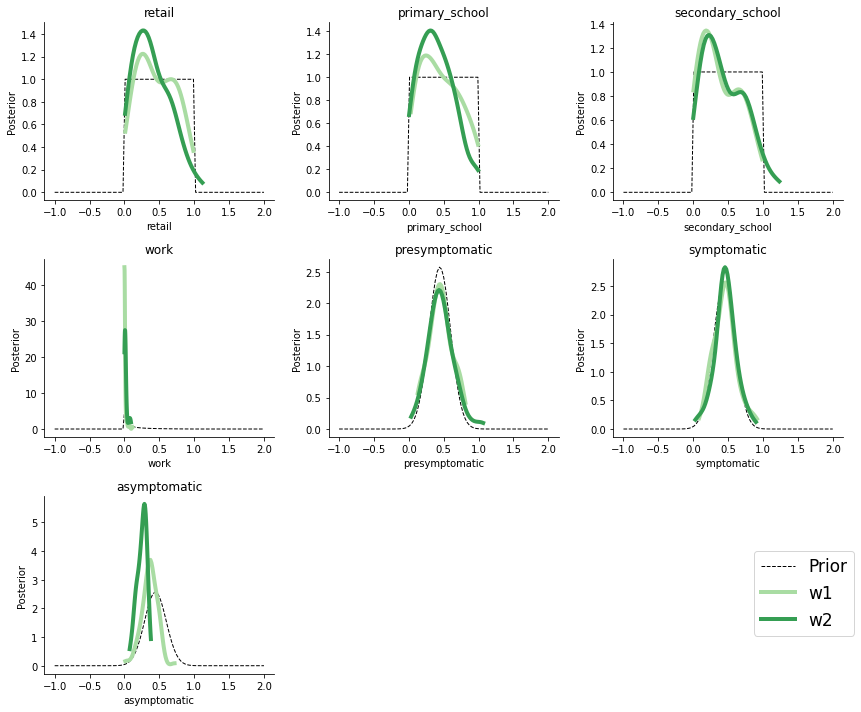

In [21]:
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=0)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

### Parameter values for all populations for each window

In [ ]:
# define colour map and line style to use in intermediate populations
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

## Compare model predictions from dynamically calibrated model against observations

### Model predictions from within dynamic calibration window
#### Get model predictions, and particle distances for each particle in the final population 

In [13]:
# Create dictionary to store results for each window
abc_sum_stats = {}

# Loop through each calibration window, defining the number of days it covered
for window, n_days in { "w1": 14, "w2":28}.items():
    
    # Create lists to store values for each particle
    distance_l, daily_preds_l, params_l, daily_preds_msoa_l = [],[],[],[]
    
    # get the history for this window    
    history_wx  = history_dict[window]   
    
    # Get parameter values
    parameter_vals_df, w = history_wx.get_distribution(m=0, t=history_wx.max_t)

    # Get the summary stats for the final population for this window ([1] means keep just the 
    # dataframe and not the array of weights)
    weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=history_wx.max_t)[1]
    
    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        
        # Get daily predictions
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]     
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        # Add daily msoa predictions for this particle to list
        daily_preds_msoa_l.append(cumulative_model_diseased_by_area)
        
        # Sum over Devon
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Add daily predictions for this particle to list
        daily_preds_l.append(cumulative_model_diseased_by_area_devon_sum.values)
        
        # Add distance to list
        distance_l.append(particle_x_dict['distance'])
        
        # Add parameter values to list
        params_l.append(parameter_vals_df.iloc[particle_no])
        
    # Add to dictionary for this window
    abc_sum_stats[window] = {'distance_l':distance_l, 'daily_preds_ls' :daily_preds_l,
                             'params_ls':params_l, 'daily_preds_msoa_l' : daily_preds_msoa_l}

#### For each window, plot the number of infections predicted over time by each particle in the final population

Text(0.5, 0.98, 'Number of infections predicted by each particle within each window')

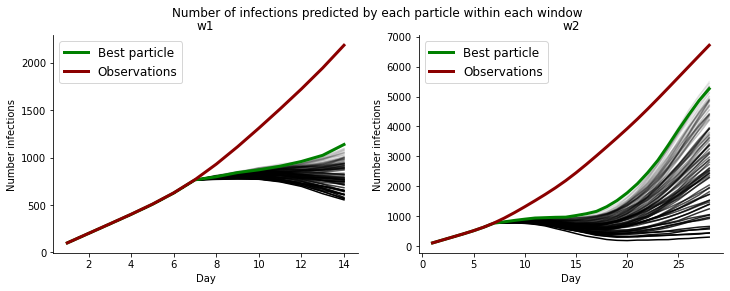

In [155]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    
    # Find the best particle
    best_particle_idx = abc_sum_stats[window]['distance_l'].index(max(abc_sum_stats[window]['distance_l']))
    
    # Get data for this window
    daily_preds_ls  = abc_sum_stats[window]['daily_preds_ls']   
    distance_l = abc_sum_stats[window]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    # define number of days these results relate to
    x=range(1,n_days+1)    
    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_ls[i],
                color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)
   
    # Add the best particle
    axes[axes_number].plot(x, daily_preds_ls[best_particle_idx], color="green", linewidth = 3,
                          label = 'Best particle')  # (1-x because high distance is bad)
   
    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(daily_preds_ls[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("{}".format(window))
    
    # Apply legend
    axes[axes_number].legend(fontsize="large")
    
    axes_number =axes_number +1
    
# Set full plot title
fig.suptitle('Number of infections predicted by each particle within each window')

#### For 2nd window, compare spatial distribution of total infections over final model window period across different particles 

In [15]:
# # Set up plotting
# %matplotlib notebook

# # Get statisitcis from final population of final window
# weighted_sum_stats = abc_sum_stats['w2']

# fig, ax = plt.subplots(figsize=(8,5))
# frames = 100 #Number of frames
# def draw(frame):
#     # plt.clf()
#     diseased_by_area =  weighted_sum_stats_t0[frame]['cumulative_model_diseased_by_area'].copy()
#     # Add a column containing the cumulative total over all the days
#     diseased_by_area['CumulativeTotal_model'] = diseased_by_area.sum(axis=1)
#     diseased_by_area['Code'] = diseased_by_area.index
#     diseased_by_area_shape = pd.merge(devon_msoa_shapes, diseased_by_area, on="Code")
#     base = diseased_by_area_shape.plot(column="CumulativeTotal_model", legend=False, ax=ax)
#     title = 'Total numer of infections over 28 days: Particle {}'.format(frame)
#     plt.axis('off')
#     plt.title(title)
#     return base
    
# def init():
#     return draw(0)

# def animate(frame):
#     return draw(frame)

# # Not sure what, if anything, this does
# from matplotlib import rc, animation
# rc('animation', html='html5')
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
# ani = animation.FuncAnimation(fig, animate, frames, interval=200, save_count=50, blit=False, init_func=init,repeat=False)
# # ani.save('basic_animation.gif', fps=1)

# # from IPython.display import HTML
# # HTML(ani.to_jshtml())


#### Plot spatial distribution of cases over time for best performing particle

In [19]:
# ## Load required spatial data
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# gis_data_dir = ("../../devon_data")
# devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)    

# ### Load observations data
# cases_msoa_daily['Code'] = cases_msoa_daily.index
# cases_msoa_daily_shape = pd.merge(devon_msoa_shapes, cases_msoa_daily, on="Code")

# ### Load model data
# daily_preds_msoa = daily_preds_msoa_l[best_particle_idx]
# daily_preds_msoa['Code'] = daily_preds_msoa.index
# daily_preds_msoa_shape = pd.merge(devon_msoa_shapes[['geometry', 'Code']], daily_preds_msoa, on="Code")

In [20]:
# # Set up plotting
# %matplotlib notebook
# fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
# frames = daily_preds_msoa_shape.shape[1] -2
# def animate(frame):
#     cases_msoa_daily_shape.plot(column='Day' + str(frame+1), legend=False, ax=ax1)
#     ax1.set_title('Observations: Day {}'.format(frame))
#     ax1.axis('off')
#     daily_preds_msoa_shape.plot(column='Day' + str(frame+1), legend=False, ax=ax2)
#     ax2.set_title('Model: Day {}'.format(frame))
#     ax2.axis('off')

# def init():
#     return animate(0)
       
# # Not sure what, if anything, this does
# from matplotlib import rc, animation
# rc('animation', html='html5')
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=200, save_count=50, blit=False,
#                               init_func=init,repeat=True)
# # from IPython.display import HTML
# # HTML(ani.to_jshtml())

### Model predictions for future

#### Set up OpenCL runner

In [ ]:
# Initialise the class so that its ready to run the model.
OpenCLRunner.init(
    iterations = 105,  repetitions = 5,observations = cases_devon_weekly, use_healthier_pop = True, 
    use_gpu = True, store_detailed_counts = False, parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR,
    snapshot_filepath = SNAPSHOT_FILEPATH,num_seed_days = 7) 
# Set constants 
OpenCLRunner.set_constants(const_params_dict)

# Run
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bestparams, sim_bestparams, obs_bestparams, out_params_bestparams, summaries_bestparams) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

### Use parameters from dynamic calibration process to run model for 105 days - new method

In [184]:
# Create dictionary to store results for each window
windows_dict_new ={}

for window in ['w1', 'w2']:

    # Define abc_history object from final window
    abc_history = history_dict[window]

    # Get dataframe of posterior parameter values
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

    # Now run N models and store the results of each one
    distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 
    negative_count = 0  # Count the number of negatives returned in the KDE posterior
    for i in range(1,df.shape[0]):
        # this sample
        param_values = df.iloc[i].to_dict()
        print(param_values)
        # If all values are more than 0 
        if all(v > 0 for v in param_values.values()):
            'All positive'
            (_distance, _sim, _obs, _out_params, _summaries) = \
                OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
            print(f"distance: {_distance}.")

            distance_l.append(_distance)
            sim_l.append(_sim)
            obs_l.append(_obs)
            out_params_l.append(_out_params)
            out_calibrated_params_l.append(param_values)
            summaries_l.append(_summaries)
        else:
            negative_count += 1
            print("added to negative count")
            
        #   
        windows_dict_new[window] = {'distance': distance_l, 'sim': sim_l, 'obs':obs_l, 'summaries': summaries_l,
                           'out_calibrated_params': out_calibrated_params_l, 'out_params': out_params_l}

# print(f"Finished sampling. Ignored {negative_count} negative samples.")

{'asymptomatic': 0.37628550129183086, 'presymptomatic': 0.1661049458958972, 'primary_school': 0.13231043087157598, 'retail': 0.07283934491046509, 'secondary_school': 0.5786383607713912, 'symptomatic': 0.44908522277540286, 'work': 0.0005997350344588071}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.55s/it]


distance: 41701.76607750886.
{'asymptomatic': 0.38969018021931723, 'presymptomatic': 0.555422898131888, 'primary_school': 0.3696104506226585, 'retail': 0.6834843697767248, 'secondary_school': 0.37754715605981, 'symptomatic': 0.5620960262489427, 'work': 0.014988812424358493}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 41485.969290732945.
{'asymptomatic': 0.32184649769635826, 'presymptomatic': 0.49808587085500494, 'primary_school': 0.2031573089710167, 'retail': 0.0037118797506330292, 'secondary_school': 0.713320085250447, 'symptomatic': 0.41030207682397735, 'work': 0.00029772219515843346}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42011.88141398746.
{'asymptomatic': 0.1839029496073219, 'presymptomatic': 0.5077894851026648, 'primary_school': 0.7458722302553774, 'retail': 0.43080909123941546, 'secondary_school': 0.10367772959747545, 'symptomatic': 0.672776085773748, 'work': 0.002518892001616581}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


distance: 42630.64703470185.
{'asymptomatic': 0.31509291082308877, 'presymptomatic': 0.4625604676529709, 'primary_school': 0.384738117198541, 'retail': 0.3110342662632345, 'secondary_school': 0.6073828502215454, 'symptomatic': 0.3585490411188159, 'work': 0.00029406870138054607}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 41872.638703324.
{'asymptomatic': 0.3358194485327822, 'presymptomatic': 0.31428340978148306, 'primary_school': 0.4825640573509812, 'retail': 0.9632208006795103, 'secondary_school': 0.02613826112392066, 'symptomatic': 0.44120233917760165, 'work': 0.00845151741195246}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42084.46172869783.
{'asymptomatic': 0.09760184871865091, 'presymptomatic': 0.5276032078058993, 'primary_school': 0.5035027480642312, 'retail': 0.9501397810053844, 'secondary_school': 0.30076163100024045, 'symptomatic': 0.4222459439924924, 'work': 0.015909486472046836}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42803.636383219964.
{'asymptomatic': 0.27926161602421007, 'presymptomatic': 0.7368726090943684, 'primary_school': 0.16911545946313278, 'retail': 0.25134173763472883, 'secondary_school': 0.2571643702748605, 'symptomatic': 0.3731038697399574, 'work': 0.010853172129334112}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42329.74003782856.
{'asymptomatic': 0.3657685600447657, 'presymptomatic': 0.258233630764341, 'primary_school': 0.9181398193655913, 'retail': 0.6072812705057089, 'secondary_school': 0.061770988140254016, 'symptomatic': 0.8024071231622016, 'work': 0.0011807544082050344}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 41748.490180730994.
{'asymptomatic': 0.20672188857230464, 'presymptomatic': 0.6433572454094542, 'primary_school': 0.1491216746754041, 'retail': 0.15904975711878175, 'secondary_school': 0.9175702170517648, 'symptomatic': 0.5290725566621556, 'work': 9.613825444236898e-05}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42421.44092082667.
{'asymptomatic': 0.17799979431597296, 'presymptomatic': 0.44911301554019123, 'primary_school': 0.28148672251451523, 'retail': 0.08264552141692726, 'secondary_school': 0.8050747787281154, 'symptomatic': 0.2658785715841127, 'work': 0.008450019555017138}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


distance: 42616.15409859739.
{'asymptomatic': 0.04362266103293766, 'presymptomatic': 0.7178013229274678, 'primary_school': 0.17626983639868593, 'retail': 0.25814212175284823, 'secondary_school': 0.9801499628938042, 'symptomatic': 0.6367578096611988, 'work': 0.0074631648699140145}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42835.23967462838.
{'asymptomatic': 0.13975325901261718, 'presymptomatic': 0.5831112569847292, 'primary_school': 0.9202338018076621, 'retail': 0.31143647038130323, 'secondary_school': 0.534544457766569, 'symptomatic': 0.5846943648181476, 'work': 0.0015244237339568111}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42609.14042975221.
{'asymptomatic': 0.5476960752399693, 'presymptomatic': 0.3130035690765609, 'primary_school': 0.4101355968509581, 'retail': 0.7368303792185724, 'secondary_school': 0.1205539680261541, 'symptomatic': 0.30172205730839347, 'work': 0.021509060293429368}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 39628.05412605671.
{'asymptomatic': 0.2515577602782446, 'presymptomatic': 0.3865324775185684, 'primary_school': 0.475064929261507, 'retail': 0.21607671919232432, 'secondary_school': 0.25235883253442476, 'symptomatic': 0.35803074827312403, 'work': 0.012803097365424206}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


distance: 42416.95852431173.
{'asymptomatic': 0.432535137764834, 'presymptomatic': 0.40272295566532124, 'primary_school': 0.196253759419888, 'retail': 0.712786843440076, 'secondary_school': 0.07368845740252922, 'symptomatic': 0.6261013552963636, 'work': 0.0012332217767624214}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 41472.67908488661.
{'asymptomatic': 0.3949590591982699, 'presymptomatic': 0.6851687104871304, 'primary_school': 0.7152725186014008, 'retail': 0.47192275036151754, 'secondary_school': 0.005679564921257457, 'symptomatic': 0.4469152180847833, 'work': 0.005388822582824823}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.23s/it]


distance: 41596.64868670596.
{'asymptomatic': 0.11590584747240229, 'presymptomatic': 0.3312998886083701, 'primary_school': 0.03367773561430182, 'retail': 0.2593239503530614, 'secondary_school': 0.828610271692845, 'symptomatic': 0.32652548073810955, 'work': 0.017328954788680646}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.28s/it]


distance: 42745.37128128238.
{'asymptomatic': 0.49099930745978926, 'presymptomatic': 0.396383408359015, 'primary_school': 0.1618073932570458, 'retail': 0.3270076278568326, 'secondary_school': 0.04149744463484717, 'symptomatic': 0.31218368758022247, 'work': 0.0048172585266995855}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.28s/it]


distance: 40464.1085279999.
{'asymptomatic': 0.37048525528387005, 'presymptomatic': 0.4533095402258689, 'primary_school': 0.7597684212911304, 'retail': 0.5551783443229898, 'secondary_school': 0.2934197845478419, 'symptomatic': 0.537818006358966, 'work': 0.013928118927512593}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 41429.12696747434.
{'asymptomatic': 0.19291528233672575, 'presymptomatic': 0.21450321477419734, 'primary_school': 0.4965721400250544, 'retail': 0.26181074995029563, 'secondary_school': 0.002273469638879949, 'symptomatic': 0.10278654512689042, 'work': 0.008655039639791235}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.28s/it]


distance: 42702.373387661704.
{'asymptomatic': 0.25762379542776165, 'presymptomatic': 0.2203161371141232, 'primary_school': 0.172440078488056, 'retail': 0.029412786616658262, 'secondary_school': 0.4089743444472703, 'symptomatic': 0.438477598256743, 'work': 0.006636779576529376}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42519.7387951169.
{'asymptomatic': 0.32049323708680527, 'presymptomatic': 0.5787498977107579, 'primary_school': 0.2777711922145578, 'retail': 0.6211938837230873, 'secondary_school': 0.01920232497398902, 'symptomatic': 0.4513716104058107, 'work': 0.023981229845218232}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


distance: 42037.06584919358.
{'asymptomatic': 0.19129426990033424, 'presymptomatic': 0.42665949021754146, 'primary_school': 0.4048156021535361, 'retail': 0.5845273802148877, 'secondary_school': 0.3829965900619702, 'symptomatic': 0.7006577819329534, 'work': 0.0066875814314791395}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


distance: 42610.82536615994.
{'asymptomatic': 0.326384947715254, 'presymptomatic': 0.31193895885006095, 'primary_school': 0.8300736758090621, 'retail': 0.19780450501968205, 'secondary_school': 0.511947610090173, 'symptomatic': 0.35314451884353065, 'work': 0.005825555383781669}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 41931.2532674831.
{'asymptomatic': 0.2887787402606635, 'presymptomatic': 0.3033841882482185, 'primary_school': 0.5804622775399535, 'retail': 0.5727958421191699, 'secondary_school': 0.4935608116632675, 'symptomatic': 0.3863673678135461, 'work': 0.027760281370643722}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


distance: 42181.13654318483.
{'asymptomatic': 0.31081461366506963, 'presymptomatic': 0.2281956054387452, 'primary_school': 0.5195427236671438, 'retail': 0.7455702391181911, 'secondary_school': 0.3972397987241013, 'symptomatic': 0.490758089838325, 'work': 0.00504581509349591}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42068.0773759907.
{'asymptomatic': 0.1733715026007326, 'presymptomatic': 0.5252877870838374, 'primary_school': 0.9380982836249169, 'retail': 0.10198757306392563, 'secondary_school': 0.6256187085457412, 'symptomatic': 0.6944732589916996, 'work': 0.006777147500755317}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42585.917927672075.
{'asymptomatic': 0.06879453299793833, 'presymptomatic': 0.7715378537075139, 'primary_school': 0.2549369115072231, 'retail': 0.46092094211540297, 'secondary_school': 0.25814637299027465, 'symptomatic': 0.45493049426481197, 'work': 0.0023599326101645113}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


distance: 42848.229855330756.
{'asymptomatic': 0.27397833419646644, 'presymptomatic': 0.48912158842423614, 'primary_school': 0.4429808043013938, 'retail': 0.329497392346195, 'secondary_school': 0.17501558212643015, 'symptomatic': 0.6716176514731133, 'work': 0.01030491876708301}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42389.27472548092.
{'asymptomatic': 0.2752356788535645, 'presymptomatic': 0.3058857225392509, 'primary_school': 0.1509916298045553, 'retail': 0.31743425719275004, 'secondary_school': 0.5456548480262705, 'symptomatic': 0.5336561566214045, 'work': 0.0015535868452278368}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


distance: 42286.175283296194.
{'asymptomatic': 0.28552303029185505, 'presymptomatic': 0.44659748236390506, 'primary_school': 0.9441634914009739, 'retail': 0.538421805878103, 'secondary_school': 0.23290279342862905, 'symptomatic': 0.5713144897974007, 'work': 0.013179348236141593}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42220.76310461558.
{'asymptomatic': 0.38763807019063956, 'presymptomatic': 0.6652326906781125, 'primary_school': 0.16868290144690248, 'retail': 0.206491192663379, 'secondary_school': 0.3724352683287663, 'symptomatic': 0.8151420778485778, 'work': 0.008646440162419016}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


distance: 41399.936396695295.
{'asymptomatic': 0.17203999043770804, 'presymptomatic': 0.7120057936188081, 'primary_school': 0.014524770471377527, 'retail': 0.4541060335052921, 'secondary_school': 0.21739187079854172, 'symptomatic': 0.5125914433417601, 'work': 0.008594486481068227}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42652.39825980785.
{'asymptomatic': 0.37482689143531694, 'presymptomatic': 0.22374217072017222, 'primary_school': 0.26681495631009944, 'retail': 0.5243282630698123, 'secondary_school': 0.07600295458170349, 'symptomatic': 0.3725218946276543, 'work': 0.026378731493445752}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.22s/it]


distance: 41836.94422358882.
{'asymptomatic': 0.325256212881827, 'presymptomatic': 0.126257571369205, 'primary_school': 0.356543465180258, 'retail': 0.05177669261849309, 'secondary_school': 0.10283123574765579, 'symptomatic': 0.48292748689136966, 'work': 0.012216817805210564}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42224.87260809632.
{'asymptomatic': 0.3071230873119774, 'presymptomatic': 0.48442161822383284, 'primary_school': 0.5858863427519098, 'retail': 0.21954042665813098, 'secondary_school': 0.661351195506285, 'symptomatic': 0.12568320920515497, 'work': 0.013650994478999036}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


distance: 41968.07258664854.
{'asymptomatic': 0.2765958375278331, 'presymptomatic': 0.21755944643794561, 'primary_school': 0.8065243871678612, 'retail': 0.4808396372498274, 'secondary_school': 0.5029319170840096, 'symptomatic': 0.4805770541822573, 'work': 0.0152855465000828}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42282.71497250245.
{'asymptomatic': 0.12824065180667074, 'presymptomatic': 0.1550541328982711, 'primary_school': 0.08016548716124297, 'retail': 0.3128528666588226, 'secondary_school': 0.705339934132913, 'symptomatic': 0.5675307556016084, 'work': 0.021766334998227672}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


distance: 42767.21112368377.
{'asymptomatic': 0.36666473115415077, 'presymptomatic': 0.22374524960055672, 'primary_school': 0.9323232909590616, 'retail': 0.5811249927038026, 'secondary_school': 0.0967851812101195, 'symptomatic': 0.2864017091402502, 'work': 0.00835146250112812}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 41803.39529752044.
{'asymptomatic': 0.44425984350265135, 'presymptomatic': 0.20568662613327357, 'primary_school': 0.6560187333088923, 'retail': 0.1353667611512308, 'secondary_school': 0.41149032357648174, 'symptomatic': 0.1767884073478727, 'work': 0.004177138904813909}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


distance: 41423.33328154992.
{'asymptomatic': 0.12934837276237626, 'presymptomatic': 0.3703448391103652, 'primary_school': 0.6398946371262275, 'retail': 0.4332495983762993, 'secondary_school': 0.4187257454046056, 'symptomatic': 0.8785525100838588, 'work': 0.009135863648018154}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.75s/it]


distance: 42689.99529431875.
{'asymptomatic': 0.1809963648932797, 'presymptomatic': 0.4403621347479908, 'primary_school': 0.53327741168989, 'retail': 0.05721728724473531, 'secondary_school': 0.3596582348034781, 'symptomatic': 0.09084172325527726, 'work': 0.019318564556379744}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.33s/it]


distance: 42647.38410640326.
{'asymptomatic': 0.19109622203763982, 'presymptomatic': 0.18385489834176383, 'primary_school': 0.1853717684708459, 'retail': 0.17776347827062536, 'secondary_school': 0.6186277371154816, 'symptomatic': 0.25651021566442045, 'work': 0.009115747127764844}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.99s/it]


distance: 42634.150104768596.
{'asymptomatic': 0.30329191649670495, 'presymptomatic': 0.8900666975919066, 'primary_school': 0.09512005842136519, 'retail': 0.06341713831624271, 'secondary_school': 0.6420863384352038, 'symptomatic': 0.6582174690445383, 'work': 0.013061749400389469}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.93s/it]


distance: 41789.216031551565.
{'asymptomatic': 0.1099531278383849, 'presymptomatic': 0.4070016978530362, 'primary_school': 0.6587642708390138, 'retail': 0.8090246079487159, 'secondary_school': 0.8529873078198456, 'symptomatic': 0.5882791448358152, 'work': 0.022590714925898245}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 42704.439268849266.
{'asymptomatic': 0.17505149946314408, 'presymptomatic': 0.5161809772434233, 'primary_school': 0.544010652488273, 'retail': 0.8290374861977872, 'secondary_school': 0.3392660750243465, 'symptomatic': 0.445703032684985, 'work': 0.003492509339317867}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.22s/it]


distance: 42662.70895610313.
{'asymptomatic': 0.24113033867089684, 'presymptomatic': 0.5282179299055871, 'primary_school': 0.31552421835763633, 'retail': 0.9037470510933487, 'secondary_school': 0.016481110737023866, 'symptomatic': 0.496582950254157, 'work': 0.019894994253892854}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42262.95965574324.
{'asymptomatic': 0.3187276721640029, 'presymptomatic': 0.7192254958265004, 'primary_school': 0.33762597119051785, 'retail': 0.011283937858201254, 'secondary_school': 0.33822909112200567, 'symptomatic': 0.4910644665291671, 'work': 0.011248256957338311}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


distance: 42030.19330143567.
{'asymptomatic': 0.37682417473534524, 'presymptomatic': 0.6229120373302052, 'primary_school': 0.5585875800233752, 'retail': 0.6241851313232416, 'secondary_school': 0.10732910419255506, 'symptomatic': 0.4941148490221747, 'work': 0.01990466820544119}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


distance: 41665.19727082341.
{'asymptomatic': 0.3072806417365732, 'presymptomatic': 0.3443886186600018, 'primary_school': 0.23627207574297454, 'retail': 0.08138282156083501, 'secondary_school': 0.5792326408229395, 'symptomatic': 0.42570489440946535, 'work': 0.013049909378429064}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42011.62421653907.
{'asymptomatic': 0.2951106224295505, 'presymptomatic': 0.09037791115255239, 'primary_school': 0.5146443925690386, 'retail': 0.6979458315347088, 'secondary_school': 0.8128301078262212, 'symptomatic': 0.1881051429844095, 'work': 0.003164531923230921}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.40s/it]


distance: 42199.748434022105.
{'asymptomatic': 0.25590639937653187, 'presymptomatic': 0.9122394632256563, 'primary_school': 0.019895455073714655, 'retail': 0.999653933802735, 'secondary_school': 0.08228574621462839, 'symptomatic': 0.843144397284234, 'work': 0.00043258957201875695}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.52s/it]


distance: 42217.88055690113.
{'asymptomatic': 0.2652473915803277, 'presymptomatic': 0.7031007670785193, 'primary_school': 0.6223033460865852, 'retail': 0.3874370232773888, 'secondary_school': 0.13504619792936906, 'symptomatic': 0.4880333333419149, 'work': 0.11388083070253613}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


distance: 42009.2190775364.
{'asymptomatic': 0.24201499330805015, 'presymptomatic': 0.15744393779514254, 'primary_school': 0.11151402585480948, 'retail': 0.39887033901454483, 'secondary_school': 0.7035881716519936, 'symptomatic': 0.23267309773826395, 'work': 0.005478683578515883}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42519.08969593217.
{'asymptomatic': 0.3500103262684575, 'presymptomatic': 0.05574031396860343, 'primary_school': 0.8392980921382209, 'retail': 0.17647523506009297, 'secondary_school': 0.5812099958768814, 'symptomatic': 0.04294999718652309, 'work': 0.019574990654836408}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42024.08696121035.
{'asymptomatic': 0.3935168720559056, 'presymptomatic': 0.5168268945124317, 'primary_school': 0.18200023493961737, 'retail': 0.09999439597216256, 'secondary_school': 0.4164530155865902, 'symptomatic': 0.5541639614061785, 'work': 0.0033756007131700164}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


distance: 41542.78379047466.
{'asymptomatic': 0.29062815740308195, 'presymptomatic': 0.3676863130167329, 'primary_school': 0.5193536401938104, 'retail': 0.571994700113549, 'secondary_school': 0.2368744947104256, 'symptomatic': 0.28546228322527345, 'work': 0.03834566802106053}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.52s/it]


distance: 42245.4352607826.
{'asymptomatic': 0.26036446323318907, 'presymptomatic': 0.2738052569180642, 'primary_school': 0.7730923647278689, 'retail': 0.5332991950722499, 'secondary_school': 0.2621418096225049, 'symptomatic': 0.5682865079218821, 'work': 0.0009531382637529145}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.51s/it]


distance: 42522.96549642385.
{'asymptomatic': 0.47556395650034483, 'presymptomatic': 0.3669159747608361, 'primary_school': 0.49540914657316765, 'retail': 0.3561635916942536, 'secondary_school': 0.10171182090315213, 'symptomatic': 0.11822152425202143, 'work': 7.464289179934565e-05}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.64s/it]


distance: 41019.644659749545.
{'asymptomatic': 0.26929880667704775, 'presymptomatic': 0.40958597819925646, 'primary_school': 0.26147690034800564, 'retail': 0.5864876944164696, 'secondary_school': 0.09854901406112754, 'symptomatic': 0.5219099577835982, 'work': 0.00722640908101533}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42401.167458502154.
{'asymptomatic': 0.22430253204479486, 'presymptomatic': 0.7351628536922579, 'primary_school': 0.09600201650379049, 'retail': 0.474914862073124, 'secondary_school': 0.17430955136066184, 'symptomatic': 0.39561304740871894, 'work': 0.0018744288135469469}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42528.44511162537.
{'asymptomatic': 0.26033410103866855, 'presymptomatic': 0.15826898206869688, 'primary_school': 0.4533720776886734, 'retail': 0.25145890131905724, 'secondary_school': 0.19610130347677648, 'symptomatic': 0.32642113793466165, 'work': 0.012848564771933505}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42493.39975182051.
{'asymptomatic': 0.20183757425628368, 'presymptomatic': 0.6475347910544506, 'primary_school': 0.8703461499200569, 'retail': 0.4086217330752953, 'secondary_school': 0.024419626723427644, 'symptomatic': 0.49958442554966365, 'work': 0.009839682315081791}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42480.61750862356.
{'asymptomatic': 0.2730703192227372, 'presymptomatic': 0.2935389038058218, 'primary_school': 0.31797162622119335, 'retail': 0.0035641745190574947, 'secondary_school': 0.23828235488681734, 'symptomatic': 0.3661025277577936, 'work': 0.004310089208230088}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.22s/it]


distance: 42444.59069436652.
{'asymptomatic': 0.3207859263072783, 'presymptomatic': 0.530124672347132, 'primary_school': 0.170103756888606, 'retail': 0.1541303904613183, 'secondary_school': 0.4164425730088376, 'symptomatic': 0.2575432110502044, 'work': 0.0022531348894202483}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.47s/it]


distance: 42059.209442849235.
{'asymptomatic': 0.2310467986917144, 'presymptomatic': 0.4720474705387341, 'primary_school': 0.6798582522477509, 'retail': 0.12481253704387879, 'secondary_school': 0.5048041269924901, 'symptomatic': 0.22021567665891298, 'work': 0.015473461074604586}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42500.25945061742.
{'asymptomatic': 0.4505625169564968, 'presymptomatic': 0.48369146276184016, 'primary_school': 0.22151472340548162, 'retail': 0.3506637795493656, 'secondary_school': 0.03408267866847284, 'symptomatic': 0.16215209208965423, 'work': 0.005895062645780304}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 41104.70766493143.
{'asymptomatic': 0.16367916235044958, 'presymptomatic': 0.36172803177048707, 'primary_school': 0.33077538373565446, 'retail': 0.5995468785537837, 'secondary_school': 0.3609964229979801, 'symptomatic': 0.9475481983849875, 'work': 0.017835297967217195}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42660.728973667305.
{'asymptomatic': 0.19260496758958937, 'presymptomatic': 0.49345499545851207, 'primary_school': 0.3450606500794721, 'retail': 0.011329581641444111, 'secondary_school': 0.5372356448414972, 'symptomatic': 0.5123011239572444, 'work': 0.002391596058574779}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42616.68416282137.
{'asymptomatic': 0.3819464602257289, 'presymptomatic': 0.3714007724310704, 'primary_school': 0.7004281896398801, 'retail': 0.3018222064173668, 'secondary_school': 0.35856139777089524, 'symptomatic': 0.09262250894204768, 'work': 0.0018593553165578366}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 41541.45283690812.
{'asymptomatic': 0.3724654786776539, 'presymptomatic': 0.1973602692898389, 'primary_school': 0.07158103209659239, 'retail': 0.7149297205613636, 'secondary_school': 0.028947790284726736, 'symptomatic': 0.21707353138800703, 'work': 0.0055263039248808305}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.51s/it]


distance: 42196.02007194812.
{'asymptomatic': 0.39058217538987633, 'presymptomatic': 0.6322374677299301, 'primary_school': 0.19041618061331048, 'retail': 0.3638608577160388, 'secondary_school': 0.2562684216372176, 'symptomatic': 0.4224987778962876, 'work': 0.0004759144713207232}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


distance: 41478.69198409681.
{'asymptomatic': 0.3823714179485146, 'presymptomatic': 0.5499294226269736, 'primary_school': 0.3149601717347385, 'retail': 0.29367119055195906, 'secondary_school': 0.18934221294849402, 'symptomatic': 0.08808540522972808, 'work': 0.004309622013975691}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 41759.51672613341.
{'asymptomatic': 0.22478850898145725, 'presymptomatic': 0.48168184450172735, 'primary_school': 0.032537326496752006, 'retail': 0.6481992985458858, 'secondary_school': 0.22941214295396034, 'symptomatic': 0.3786905059389959, 'work': 0.004821238673741814}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42522.952810642244.
{'asymptomatic': 0.3963298473044186, 'presymptomatic': 0.3253552675568582, 'primary_school': 0.17421431833140608, 'retail': 0.05996977862688596, 'secondary_school': 0.11353284942173987, 'symptomatic': 0.4072773096254653, 'work': 0.011566153280817185}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 41506.12983614135.
{'asymptomatic': 0.43853775815465734, 'presymptomatic': 0.6924216518221323, 'primary_school': 0.1663222495552384, 'retail': 0.18506935806827207, 'secondary_school': 0.11697316581087022, 'symptomatic': 0.3512791268589495, 'work': 0.004193232737287083}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 40824.37973242218.
{'asymptomatic': 0.1321008369707926, 'presymptomatic': 0.6922161938747993, 'primary_school': 0.30435147276280283, 'retail': 0.34260892202737503, 'secondary_school': 0.2141534127465746, 'symptomatic': 0.44599442288336083, 'work': 0.0019086499759137145}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42752.66996888223.
{'asymptomatic': 0.17753217556668613, 'presymptomatic': 0.7085882316934763, 'primary_school': 0.583159580470012, 'retail': 0.11949472456729157, 'secondary_school': 0.12814123858543217, 'symptomatic': 0.381697408636685, 'work': 0.0025238547695921945}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42700.15869100497.
{'asymptomatic': 0.2903466768817909, 'presymptomatic': 0.4370507944744606, 'primary_school': 0.985020265848167, 'retail': 0.18092077364800702, 'secondary_school': 0.33258540627239186, 'symptomatic': 0.33948206012902205, 'work': 0.012953534175313901}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42251.73587640549.
{'asymptomatic': 0.4843940841369287, 'presymptomatic': 0.46731182451604864, 'primary_school': 0.0888208779058664, 'retail': 0.6114099134938805, 'secondary_school': 0.021876057619430685, 'symptomatic': 0.25665823320603937, 'work': 0.0012288173046934756}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 40961.611125669755.
{'asymptomatic': 0.2114984198207734, 'presymptomatic': 0.10638048304719191, 'primary_school': 0.9155262848471198, 'retail': 0.101835499091779, 'secondary_school': 0.7047246661391396, 'symptomatic': 0.35083062935723125, 'work': 0.017769050701807565}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42564.51842335859.
{'asymptomatic': 0.18917980295201056, 'presymptomatic': 0.8427872257807199, 'primary_school': 0.2932960971507699, 'retail': 0.38044920805199994, 'secondary_school': 0.5138329734605289, 'symptomatic': 0.5724664779204729, 'work': 0.0003587131441471143}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42466.86726561116.
{'asymptomatic': 0.30821777337811984, 'presymptomatic': 0.8240140762890865, 'primary_school': 0.8179945171231776, 'retail': 0.2579737902339547, 'secondary_school': 0.020962233430652687, 'symptomatic': 0.3703166739215523, 'work': 0.002064004577899026}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.50s/it]


distance: 42015.54763228376.
{'asymptomatic': 0.3252434768179009, 'presymptomatic': 0.13486614818790407, 'primary_school': 0.3186939635756479, 'retail': 0.7772808284453031, 'secondary_school': 0.5673605529179039, 'symptomatic': 0.9902871143163953, 'work': 0.006142840722714231}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]


distance: 42141.394433875736.
{'asymptomatic': 0.20440034272378094, 'presymptomatic': 0.09478178820725816, 'primary_school': 0.05964281979522612, 'retail': 0.136025084894018, 'secondary_school': 0.061252426113051595, 'symptomatic': 0.21956768528548246, 'work': 0.018252746204107405}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.47s/it]


distance: 42740.64239734933.
{'asymptomatic': 0.3513914162579373, 'presymptomatic': 0.48146988637283816, 'primary_school': 0.5665173742859816, 'retail': 0.8471563838374938, 'secondary_school': 0.611554997357946, 'symptomatic': 0.4370801356462571, 'work': 0.0003231644267235567}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 41603.49984983417.
{'asymptomatic': 0.3619640206124989, 'presymptomatic': 0.24858535392350475, 'primary_school': 0.7633737932347273, 'retail': 0.2293269665500462, 'secondary_school': 0.49966270527617807, 'symptomatic': 0.26037897925680165, 'work': 0.00621163653125419}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.61s/it]


distance: 41721.6637766007.
{'asymptomatic': 0.23091856203963404, 'presymptomatic': 0.8018110580584114, 'primary_school': 0.4561082982886785, 'retail': 0.6886831606037342, 'secondary_school': 0.689158667641628, 'symptomatic': 0.36426195091643065, 'work': 0.010874918679478847}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.47s/it]


distance: 42411.545962080876.
{'asymptomatic': 0.3501486601953844, 'presymptomatic': 0.6218253485079775, 'primary_school': 0.6925909379472578, 'retail': 0.22681902860210362, 'secondary_school': 0.09880961263518802, 'symptomatic': 0.39380426263967605, 'work': 0.0003263195121559277}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


distance: 42006.78838179683.
{'asymptomatic': 0.5067384262598271, 'presymptomatic': 0.3949330796123787, 'primary_school': 0.5692625522091277, 'retail': 0.26484259484452644, 'secondary_school': 0.10467833166065336, 'symptomatic': 0.2081771476651193, 'work': 0.011585564549797034}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


distance: 40254.836039723836.
{'asymptomatic': 0.38944829347135956, 'presymptomatic': 0.49649520078408826, 'primary_school': 0.6928699912346518, 'retail': 0.6490928995547791, 'secondary_school': 0.17896566288456214, 'symptomatic': 0.5441756825384102, 'work': 0.0007958751161489652}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.47s/it]


distance: 41506.0718828359.
{'asymptomatic': 0.30757236626567463, 'presymptomatic': 0.6965339604834495, 'primary_school': 0.45980466050554875, 'retail': 0.04486899443585258, 'secondary_school': 0.34066602504413634, 'symptomatic': 0.15153164959357018, 'work': 0.007092799778521951}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


distance: 42247.92819568121.
{'asymptomatic': 0.45628681817706707, 'presymptomatic': 0.2518535129494186, 'primary_school': 0.6614385423257183, 'retail': 0.001544018052031991, 'secondary_school': 0.3257212865816223, 'symptomatic': 0.36287993181516687, 'work': 0.005880739759852008}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


distance: 40784.351873550906.
{'asymptomatic': 0.3829633508419128, 'presymptomatic': 0.49991192904454207, 'primary_school': 0.7927782958538465, 'retail': 0.7361267498470735, 'secondary_school': 0.1442541073913021, 'symptomatic': 0.48517483798616157, 'work': 0.005609568031761343}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


distance: 41534.332858462476.
{'asymptomatic': 0.3382615506153785, 'presymptomatic': 0.427408391261218, 'primary_school': 0.3855750901706074, 'retail': 0.8978153251326546, 'secondary_school': 0.5316770567230322, 'symptomatic': 0.2918684680975233, 'work': 0.009276901740445037}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 41994.09193740227.
{'asymptomatic': 0.04637240276182996, 'presymptomatic': 0.5675425658071144, 'primary_school': 0.5742948648838538, 'retail': 0.6716560020310567, 'secondary_school': 0.08927549708180046, 'symptomatic': 0.5485035802630385, 'work': 0.019478216125195923}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42866.6229432217.
{'asymptomatic': 0.16324420895498204, 'presymptomatic': 0.7239009211516675, 'primary_school': 0.9103044335552019, 'retail': 0.6848240245027384, 'secondary_school': 0.09846993448550259, 'symptomatic': 0.0863245990567324, 'work': 0.01289166659468025}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42712.803212068284.
{'asymptomatic': 0.26588094377623006, 'presymptomatic': 0.4043341351353795, 'primary_school': 0.493147985670406, 'retail': 0.23524784617005734, 'secondary_school': 0.2830769459984709, 'symptomatic': 0.38338328451075177, 'work': 0.07543060533699769}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.46s/it]


distance: 42284.51396921335.
{'asymptomatic': 0.15803922212759605, 'presymptomatic': 1.012244292493318, 'primary_school': 0.6844703441164026, 'retail': 0.5400919411994051, 'secondary_school': 0.5783838743095531, 'symptomatic': 0.589106467891576, 'work': 0.03079275712780252}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.52s/it]


distance: 42470.39526455145.
{'asymptomatic': 0.23807897935486216, 'presymptomatic': 0.6027680637615436, 'primary_school': 0.5260647483143601, 'retail': 0.24278003395250075, 'secondary_school': 0.0381029606021459, 'symptomatic': 0.2772352443064189, 'work': 0.01809640597785333}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42357.777636513376.
{'asymptomatic': 0.19447642355951222, 'presymptomatic': 0.32357597213462025, 'primary_school': 0.15028372337461854, 'retail': 0.8278908628595183, 'secondary_school': 0.266752942714453, 'symptomatic': 0.34792860303252654, 'work': 0.008318611166193762}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


distance: 42621.94408313032.
{'asymptomatic': 0.13872286279563117, 'presymptomatic': 0.7802967840787463, 'primary_school': 0.17461485356106612, 'retail': 0.09249906285821688, 'secondary_school': 0.7322824644857877, 'symptomatic': 0.5289005787513477, 'work': 0.02994752793672406}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42669.4944265528.
{'asymptomatic': 0.15868130907821584, 'presymptomatic': 0.7897332129420823, 'primary_school': 0.2430282649998682, 'retail': 0.3349395100375016, 'secondary_school': 0.2090519563693216, 'symptomatic': 0.5655539733068675, 'work': 0.035452931469315135}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


distance: 42637.6506002438.
{'asymptomatic': 0.232395310997848, 'presymptomatic': 0.3333525490661751, 'primary_school': 0.42659536970841583, 'retail': 0.4451979731271065, 'secondary_school': 0.4990496337567229, 'symptomatic': 0.3969240151606925, 'work': 0.02046797294299072}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


distance: 42368.022514214346.
{'asymptomatic': 0.16682025630321193, 'presymptomatic': 0.5290755013579966, 'primary_school': 0.7225799917142142, 'retail': 0.015413980518540538, 'secondary_school': 0.5674980941600443, 'symptomatic': 0.5505147418977182, 'work': 0.08506426879716467}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42505.81512634341.
{'asymptomatic': 0.17258096037298318, 'presymptomatic': 1.096170389189873, 'primary_school': 0.931394912703498, 'retail': 0.7746327765827677, 'secondary_school': 0.41206915948805, 'symptomatic': 0.6055125895441346, 'work': 0.008534943259859663}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42427.916478835374.
{'asymptomatic': 0.04004737021252835, 'presymptomatic': 0.8859841838303952, 'primary_school': 0.9353669925357349, 'retail': 0.1004210080221814, 'secondary_school': 0.117819626173745, 'symptomatic': 0.7038461535068624, 'work': 0.0012009902031488162}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42862.45680465746.
{'asymptomatic': 0.2734354873840715, 'presymptomatic': 0.05621702154625283, 'primary_school': 0.5443011438298013, 'retail': 0.1803249305641282, 'secondary_school': 0.13885818621576718, 'symptomatic': 0.7236784487100028, 'work': 0.01519919545619513}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42374.16982340307.
{'asymptomatic': 0.14385056810046912, 'presymptomatic': 0.6042989473744294, 'primary_school': 0.3621762915446103, 'retail': 0.3110536811924588, 'secondary_school': 0.7415910826283691, 'symptomatic': 0.7117605087440305, 'work': 0.017943035397109418}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42626.110882205445.
{'asymptomatic': 0.24910955052649528, 'presymptomatic': 0.48235382863344684, 'primary_school': 0.4694425371298481, 'retail': 0.31780555666615395, 'secondary_school': 0.1605486335097822, 'symptomatic': 0.5192041453834835, 'work': 0.026659004626767506}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


distance: 42378.49459065355.
{'asymptomatic': 0.16498652826716056, 'presymptomatic': 0.5230687164165427, 'primary_school': 0.43328335842813337, 'retail': 0.8233271810262708, 'secondary_school': 0.7069887465477623, 'symptomatic': 0.7642404032830089, 'work': 0.002254081291777916}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


distance: 42513.63920749918.
{'asymptomatic': 0.09631238324651811, 'presymptomatic': 0.7761698308570171, 'primary_school': 0.14277202205630932, 'retail': 0.058345356651690744, 'secondary_school': 0.1678088709636546, 'symptomatic': 0.4902705136284239, 'work': 0.08086624795716277}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


distance: 42776.950777804006.
{'asymptomatic': 0.0587691177007223, 'presymptomatic': 0.5805694005147249, 'primary_school': 0.17847897788540962, 'retail': 0.5135163649345091, 'secondary_school': 0.7581471810811884, 'symptomatic': 0.8405782304289453, 'work': 0.007377842183975591}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.90s/it]


distance: 42809.74823701257.
{'asymptomatic': 0.241063505670944, 'presymptomatic': 0.5727610611387293, 'primary_school': 0.3578809162026026, 'retail': 0.0844122287345081, 'secondary_school': 0.2132051251367681, 'symptomatic': 0.4450942084411631, 'work': 0.07203834794840752}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.88s/it]


distance: 42350.862810860854.
{'asymptomatic': 0.27814913257528967, 'presymptomatic': 0.19931950845331822, 'primary_school': 0.04439937944203262, 'retail': 0.27969247738937, 'secondary_school': 0.10178492208984154, 'symptomatic': 0.26818600912316853, 'work': 0.046109742384595295}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.71s/it]


distance: 42339.713671288.
{'asymptomatic': 0.23688450339406003, 'presymptomatic': 0.4292749445763355, 'primary_school': 0.27078437398020855, 'retail': 0.021446788272836026, 'secondary_school': 0.4115249373149191, 'symptomatic': 0.48335813102812436, 'work': 0.05842305916179718}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 42376.390653576884.
{'asymptomatic': 0.20930444689429814, 'presymptomatic': 0.37818157600035396, 'primary_school': 0.6969570249365762, 'retail': 0.3829909613751025, 'secondary_school': 0.5146002562546238, 'symptomatic': 0.4416862799006905, 'work': 0.09335424468379687}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42319.55738940532.
{'asymptomatic': 0.19062315890777262, 'presymptomatic': 0.0772135886068959, 'primary_school': 0.6368200054257668, 'retail': 0.6884959563176458, 'secondary_school': 0.15483846944701551, 'symptomatic': 0.3479874755981465, 'work': 0.025544068315805427}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42706.222806337355.
{'asymptomatic': 0.3173473576470707, 'presymptomatic': 0.16566749515310486, 'primary_school': 0.40246537423541007, 'retail': 0.23561278650386008, 'secondary_school': 0.11379456111315008, 'symptomatic': 0.7087353970807001, 'work': 0.015049526939029171}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42131.75615800669.
{'asymptomatic': 0.17341490197845358, 'presymptomatic': 0.7434574689111615, 'primary_school': 0.3395753612629362, 'retail': 0.02836286322132349, 'secondary_school': 0.6966948683108902, 'symptomatic': 0.6200179545569643, 'work': 0.00619818680009278}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


distance: 42494.97244204377.
{'asymptomatic': 0.2816769816533913, 'presymptomatic': 0.26167279893442014, 'primary_school': 0.14656827319038535, 'retail': 0.20303497819511238, 'secondary_school': 0.09427040048515453, 'symptomatic': 0.3165608639165114, 'work': 0.06764661573313334}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.23s/it]


distance: 42292.47840644972.
{'asymptomatic': 0.3062758375834162, 'presymptomatic': 0.3442679970312926, 'primary_school': 0.3718020248762549, 'retail': 0.22972317224692268, 'secondary_school': 0.208481709087647, 'symptomatic': 0.5203397912889541, 'work': 0.0028866962648461487}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.23s/it]


distance: 42288.7104609557.
{'asymptomatic': 0.18874738144300673, 'presymptomatic': 0.5587620515300629, 'primary_school': 1.1501541769233372, 'retail': 0.31916038765498245, 'secondary_school': 0.8141271736996586, 'symptomatic': 0.32651718086810483, 'work': 0.016927120407868753}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42462.25480685362.
{'asymptomatic': 0.24082170981718165, 'presymptomatic': 0.16397590939841122, 'primary_school': 0.7109415391230074, 'retail': 0.6365852133372931, 'secondary_school': 0.12889222402889244, 'symptomatic': 0.41744544779433507, 'work': 0.0076373578506640435}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.40s/it]


distance: 42496.09747875381.
{'asymptomatic': 0.1225007577996445, 'presymptomatic': 0.5362951429084397, 'primary_school': 0.34326414331958055, 'retail': 0.09690506918437695, 'secondary_school': 0.33991301283631475, 'symptomatic': 0.30274633591888367, 'work': 0.028199915407867482}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.22s/it]


distance: 42758.93517495547.
{'asymptomatic': 0.21373521639945792, 'presymptomatic': 0.3835538673372987, 'primary_school': 0.3128018263296999, 'retail': 0.7798307632865593, 'secondary_school': 0.776636986623583, 'symptomatic': 0.49082032440346396, 'work': 0.0218058938519314}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.29s/it]


distance: 42444.36813604964.
{'asymptomatic': 0.1796296858177134, 'presymptomatic': 0.32401710199394107, 'primary_school': 0.34113270271236246, 'retail': 0.341791344410154, 'secondary_school': 0.8088820803596923, 'symptomatic': 0.3860461236283601, 'work': 0.016268482821238724}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42588.22619393661.
{'asymptomatic': 0.08966842498761524, 'presymptomatic': 0.5977371287945982, 'primary_school': 0.05272920765158613, 'retail': 0.27835373384545953, 'secondary_school': 1.370261356167145, 'symptomatic': 0.7330019114520313, 'work': 0.022307136028746753}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42640.939496780135.
{'asymptomatic': 0.2735738812398461, 'presymptomatic': 0.2933542862863668, 'primary_school': 0.11396846482169927, 'retail': 0.6960141307048706, 'secondary_school': 0.17067399799252828, 'symptomatic': 0.6111931213791844, 'work': 0.0079658166264385}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42465.79805358039.
{'asymptomatic': 0.16018787534414697, 'presymptomatic': 0.9564259844329149, 'primary_school': 0.32198819746723084, 'retail': 0.28427846250540645, 'secondary_school': 0.6792131269125032, 'symptomatic': 0.647406791853003, 'work': 0.010752703186214439}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


distance: 42579.302405528964.
{'asymptomatic': 0.15987279456384756, 'presymptomatic': 0.7998065958577084, 'primary_school': 0.8762585211456779, 'retail': 0.4204776667441455, 'secondary_school': 0.00937152553598844, 'symptomatic': 0.14432121504545534, 'work': 0.002923305115312573}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


distance: 42689.788756730835.
{'asymptomatic': 0.2682927348178451, 'presymptomatic': 0.17034712785407355, 'primary_school': 0.23336106622131747, 'retail': 0.05003301359891657, 'secondary_school': 0.34802846433736595, 'symptomatic': 0.48368962142706035, 'work': 0.09066009669883866}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42289.609727374656.
{'asymptomatic': 0.15277123112928667, 'presymptomatic': 0.22811529910425685, 'primary_school': 0.5296658149083311, 'retail': 0.5123898450446172, 'secondary_school': 0.6031166781132156, 'symptomatic': 0.5448979573668332, 'work': 0.007271387097449917}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


distance: 42677.129311052915.
{'asymptomatic': 0.14355887802360728, 'presymptomatic': 0.4836297831794696, 'primary_school': 0.057688450135572084, 'retail': 0.2283447368503385, 'secondary_school': 0.7380113557512806, 'symptomatic': 0.6329689595620737, 'work': 0.0066498512885009055}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42715.166279267265.
{'asymptomatic': 0.1333111600004376, 'presymptomatic': 0.6812839522072516, 'primary_school': 0.15928272952319295, 'retail': 0.14414175422483638, 'secondary_school': 1.021540700149861, 'symptomatic': 0.5665021313780658, 'work': 0.007426903601253873}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42684.123931952585.
{'asymptomatic': 0.26457656707728183, 'presymptomatic': 0.5061337294883549, 'primary_school': 0.44242023268842395, 'retail': 0.24650628624765022, 'secondary_school': 0.4225212292239613, 'symptomatic': 0.47666581649826223, 'work': 0.00966502556144348}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42379.28106426374.
{'asymptomatic': 0.31250941800975646, 'presymptomatic': 0.1000652044996668, 'primary_school': 0.17549991156370098, 'retail': 0.738641045121045, 'secondary_school': 0.009951623190881373, 'symptomatic': 0.27891799983677507, 'work': 0.019504641886830383}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


distance: 42365.50034978205.
{'asymptomatic': 0.18160434277103862, 'presymptomatic': 0.6262703068737412, 'primary_school': 0.30080162075972394, 'retail': 0.15044064750368408, 'secondary_school': 0.7960006429691927, 'symptomatic': 0.4312655710368254, 'work': 0.008478710695170926}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.08s/it]


distance: 42585.77515991948.
{'asymptomatic': 0.15156803737151098, 'presymptomatic': 0.48949707631964184, 'primary_school': 0.31175008733671505, 'retail': 0.3924879506878546, 'secondary_school': 0.15003385574389838, 'symptomatic': 0.5033260257091403, 'work': 0.06789903431302619}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.20s/it]


distance: 42678.19163131802.
{'asymptomatic': 0.18793938503115762, 'presymptomatic': 0.5392302507057192, 'primary_school': 0.2594280803630014, 'retail': 0.6280925044173878, 'secondary_school': 0.6783033094449309, 'symptomatic': 0.4938876574756022, 'work': 0.0006996010314481993}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.65s/it]


distance: 42574.973115848494.
{'asymptomatic': 0.24165823395217925, 'presymptomatic': 0.398326632203303, 'primary_school': 0.6296876355576124, 'retail': 0.5472344843312651, 'secondary_school': 0.5398016189189437, 'symptomatic': 0.49110966311979454, 'work': 0.02032915176409581}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42346.82531981727.
{'asymptomatic': 0.2710400794835041, 'presymptomatic': 0.28284547439487817, 'primary_school': 0.49444362294243804, 'retail': 1.1581820750193683, 'secondary_school': 0.5016163322568378, 'symptomatic': 0.35575161787475, 'work': 0.013396797512125275}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.61s/it]


distance: 42438.8764469782.
{'asymptomatic': 0.21114249856992875, 'presymptomatic': 0.306724570695046, 'primary_school': 0.4218690998858443, 'retail': 0.26478532220744944, 'secondary_school': 0.7203525205207939, 'symptomatic': 0.20987813809779776, 'work': 0.015920187028274753}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.82s/it]


distance: 42510.37739773202.
{'asymptomatic': 0.10836295218391084, 'presymptomatic': 0.7471778920300414, 'primary_school': 0.1775917861257468, 'retail': 0.28932438153511575, 'secondary_school': 1.0466561187170036, 'symptomatic': 0.7355343351691928, 'work': 0.0021520044340120267}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.95s/it]


distance: 42617.78099044085.
{'asymptomatic': 0.19861564305118795, 'presymptomatic': 0.23372437139013785, 'primary_school': 0.14752087074154543, 'retail': 0.16379592262184545, 'secondary_school': 0.6377453052465533, 'symptomatic': 0.5021074424723492, 'work': 0.030979665404307452}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


distance: 42564.269701827754.
{'asymptomatic': 0.243622115760328, 'presymptomatic': 0.23699932270177723, 'primary_school': 0.5695798650206093, 'retail': 0.636990058301262, 'secondary_school': 0.5266918283829799, 'symptomatic': 0.5826633055031708, 'work': 0.02616232623832615}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.80s/it]


distance: 42348.50728750704.
{'asymptomatic': 0.20910985579277572, 'presymptomatic': 0.739422747618867, 'primary_school': 0.07241121307780596, 'retail': 0.15134722124635666, 'secondary_school': 0.17723772694038278, 'symptomatic': 0.5975718509029445, 'work': 0.012661308209468461}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.14s/it]


distance: 42538.317340536014.
{'asymptomatic': 0.11682201894922067, 'presymptomatic': 0.6940186164095556, 'primary_school': 0.6627238370089282, 'retail': 0.24940055523923074, 'secondary_school': 0.4132231751357429, 'symptomatic': 0.10566938546212795, 'work': 0.0020956434316372853}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.57s/it]


distance: 42817.18329006352.
{'asymptomatic': 0.17697146241885833, 'presymptomatic': 0.6963324624080988, 'primary_school': 0.7606633318905262, 'retail': 0.27924278216255416, 'secondary_school': 0.403464187503791, 'symptomatic': 0.009060620647641463, 'work': 0.02319433982191138}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


distance: 42640.1413451239.
{'asymptomatic': 0.22030959373585202, 'presymptomatic': 0.18245492308791697, 'primary_school': 0.6291781168155343, 'retail': 0.6595067040156988, 'secondary_school': 0.2643598175936612, 'symptomatic': 0.4405908795986552, 'work': 0.024926140067051114}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


distance: 42574.165286719326.
{'asymptomatic': 0.2369209499138459, 'presymptomatic': 0.18236825318875502, 'primary_school': 0.5604002050101107, 'retail': 0.44292110654118194, 'secondary_school': 0.4126660924012499, 'symptomatic': 0.5452602378876633, 'work': 0.05536974200854226}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.57s/it]


distance: 42465.677964371724.
{'asymptomatic': 0.08279910083238637, 'presymptomatic': 0.3158229962340485, 'primary_school': 0.16887364565068508, 'retail': 0.2698940260043628, 'secondary_school': 0.852532557260106, 'symptomatic': 0.7574220043636153, 'work': 0.028632552964737747}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.69s/it]


distance: 42786.90567651842.
{'asymptomatic': 0.2898183160976369, 'presymptomatic': 0.08329239515309708, 'primary_school': 0.7806964400282717, 'retail': 0.2195489165422933, 'secondary_school': 0.5210632111500935, 'symptomatic': 0.07015677665330503, 'work': 0.045639289681190576}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.83s/it]


distance: 42397.27184399433.
{'asymptomatic': 0.11523273881325184, 'presymptomatic': 0.6573554730477289, 'primary_school': 0.4931139463620796, 'retail': 0.9719090521704326, 'secondary_school': 0.8280682595015708, 'symptomatic': 0.721832379826191, 'work': 0.009387536382011018}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


distance: 42602.93789746509.
{'asymptomatic': 0.14474016907424553, 'presymptomatic': 0.06962756156222799, 'primary_school': 0.2074467212942422, 'retail': 0.8593636455199821, 'secondary_school': 0.8946438928637651, 'symptomatic': 0.5233446827267825, 'work': 0.026981713770426213}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.20s/it]


distance: 42714.46144247649.
{'asymptomatic': 0.15526724471092324, 'presymptomatic': 0.8083667027142553, 'primary_school': 0.5146068363064842, 'retail': 0.42629910672800075, 'secondary_school': 0.0024042194942439643, 'symptomatic': 0.7450793598673331, 'work': 0.01853085902226178}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.92s/it]


distance: 42631.93227214977.
{'asymptomatic': 0.24641184535774724, 'presymptomatic': 0.44080767939713283, 'primary_school': 0.7215080077576359, 'retail': 0.09375379221886798, 'secondary_school': 0.2619365590811329, 'symptomatic': 0.5833446165200629, 'work': 0.026699174534455066}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.51s/it]


distance: 42338.74218533459.
{'asymptomatic': 0.2395816672531512, 'presymptomatic': 0.42179032299098573, 'primary_school': 0.44377369941175915, 'retail': 0.3064964010090231, 'secondary_school': 0.5078421571824572, 'symptomatic': 0.34611323020059603, 'work': 0.02781086371655263}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


distance: 42475.97963863731.
{'asymptomatic': 0.09049698280452419, 'presymptomatic': 0.4830591431090488, 'primary_school': 0.5104787221818979, 'retail': 0.6813657707757989, 'secondary_school': 1.022426475357398, 'symptomatic': 0.5326746907811559, 'work': 0.001485225931033413}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42732.62669664051.
{'asymptomatic': 0.2046679732043683, 'presymptomatic': 0.5484503506479086, 'primary_school': 0.6658645134020331, 'retail': 0.13667740211781376, 'secondary_school': 0.11676801621405025, 'symptomatic': 0.42362175407584385, 'work': 0.05666594658779105}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


distance: 42478.92307224644.
{'asymptomatic': 0.15274095754591754, 'presymptomatic': 0.8802696230742261, 'primary_school': 0.4088844793340341, 'retail': 0.4379322082363035, 'secondary_school': 0.1453786338131744, 'symptomatic': 0.36537089198126355, 'work': 0.017196035731382935}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42630.677934044325.
{'asymptomatic': 0.23566040235257088, 'presymptomatic': 0.5542515552936979, 'primary_school': 0.757544687946376, 'retail': 0.7715946491485128, 'secondary_school': 0.5583197198333476, 'symptomatic': 0.8569671790511365, 'work': 0.019894657576917704}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


distance: 42228.22255997222.
{'asymptomatic': 0.1890976113426976, 'presymptomatic': 0.6609744323017327, 'primary_school': 0.2031754052635216, 'retail': 0.38121706965179436, 'secondary_school': 0.8220398166894932, 'symptomatic': 0.3543025045082103, 'work': 0.03222337243518833}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42492.56467713288.
{'asymptomatic': 0.17785095732730186, 'presymptomatic': 0.6686552152436191, 'primary_school': 0.24848109779996017, 'retail': 0.32029015606554195, 'secondary_school': 0.1590773411674041, 'symptomatic': 0.3490150843547731, 'work': 0.03170617132669214}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


distance: 42652.560474642814.
{'asymptomatic': 0.1338846512229061, 'presymptomatic': 0.8989374281506611, 'primary_school': 0.32335319914709915, 'retail': 0.35459030485691767, 'secondary_school': 0.2159893049586294, 'symptomatic': 0.7180201044412209, 'work': 0.02855450448633772}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


distance: 42677.70137501849.
{'asymptomatic': 0.2398933034487856, 'presymptomatic': 0.5393869200532051, 'primary_school': 1.0207490041659955, 'retail': 1.323003791787754, 'secondary_school': 0.09914615794691717, 'symptomatic': 0.481287727994013, 'work': 0.026630388657426594}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42331.546732087074.
{'asymptomatic': 0.2634915408259284, 'presymptomatic': 0.4938588500343246, 'primary_school': 0.5631972988778752, 'retail': 0.6199349486650096, 'secondary_school': 0.036009624365526766, 'symptomatic': 0.5743250279071979, 'work': 0.00014233775930901776}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.25s/it]


distance: 42297.95190510946.
{'asymptomatic': 0.09452660563007206, 'presymptomatic': 0.9022170051414401, 'primary_school': 0.14788275862795291, 'retail': 0.21074016779687854, 'secondary_school': 1.2439273285328376, 'symptomatic': 0.5655545429515004, 'work': 0.00443984680927781}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


distance: 42670.80279856526.
{'asymptomatic': 0.2209975919965379, 'presymptomatic': 0.3266248430703663, 'primary_school': 0.21215080179471307, 'retail': 0.9032645736909074, 'secondary_school': 0.18896401425894307, 'symptomatic': 0.22314730399006807, 'work': 0.049041686821640354}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


distance: 42533.73024444045.
{'asymptomatic': 0.13707489666544118, 'presymptomatic': 0.521418564544329, 'primary_school': 0.4684781320389612, 'retail': 0.029430767248818795, 'secondary_school': 0.12199604428083036, 'symptomatic': 0.4103253651176179, 'work': 0.019704216316913416}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.14s/it]


distance: 42786.64256637612.
{'asymptomatic': 0.26610698820372186, 'presymptomatic': 0.19356840742816028, 'primary_school': 1.119456111668926, 'retail': 0.37791178028199196, 'secondary_school': 0.49837244621502375, 'symptomatic': 0.31055079110954636, 'work': 0.025279636893566652}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42368.01684345578.
{'asymptomatic': 0.21566463898872246, 'presymptomatic': 0.2694234352631135, 'primary_school': 0.6664439392066356, 'retail': 0.12674532749869594, 'secondary_school': 0.42720053216341974, 'symptomatic': 0.10290995671718048, 'work': 0.005934675699954612}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42630.53895765091.
{'asymptomatic': 0.23375857160883207, 'presymptomatic': 0.7974298535667655, 'primary_school': 0.5619654699291431, 'retail': 0.167874787603593, 'secondary_school': 0.0251952225583753, 'symptomatic': 0.45368949445390055, 'work': 0.010647009604465168}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42354.53494768629.
{'asymptomatic': 0.11401980493212932, 'presymptomatic': 0.18520730570228644, 'primary_school': 0.5266360217330541, 'retail': 0.6871819656687072, 'secondary_school': 0.37526481348432467, 'symptomatic': 0.6433852099582312, 'work': 0.013578284268730118}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42783.858634118544.
{'asymptomatic': 0.12391196372324073, 'presymptomatic': 0.5282823506489991, 'primary_school': 0.26536951605143816, 'retail': 0.281549228907727, 'secondary_school': 0.2916717540625397, 'symptomatic': 0.5532044104576987, 'work': 0.02547567258764496}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.16s/it]


distance: 42749.90652868266.
{'asymptomatic': 0.173481933892911, 'presymptomatic': 0.4408375779751619, 'primary_school': 0.6070514495346738, 'retail': 0.9113842833214247, 'secondary_school': 0.8680347095017976, 'symptomatic': 0.33586665892187106, 'work': 0.03888287126332332}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42474.8201739258.
{'asymptomatic': 0.09981171920672081, 'presymptomatic': 0.4621663722867898, 'primary_school': 0.341308520413783, 'retail': 0.01352628135500885, 'secondary_school': 0.643069134064002, 'symptomatic': 0.4190626192849355, 'work': 0.024499855497029654}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.48s/it]


distance: 42795.63065595767.
{'asymptomatic': 0.267934357596075, 'presymptomatic': 0.48093951271640034, 'primary_school': 0.6412829746662728, 'retail': 0.3131462997669265, 'secondary_school': 0.06464183320183159, 'symptomatic': 0.5505786835330837, 'work': 1.597482342056457e-05}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42436.6374279975.
{'asymptomatic': 0.19362142051121742, 'presymptomatic': 0.7281102424048697, 'primary_school': 0.46081722968900785, 'retail': 0.1604301862955421, 'secondary_school': 0.7901301456362317, 'symptomatic': 0.5730991626158071, 'work': 0.012764025687898141}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


distance: 42406.12053193927.
{'asymptomatic': 0.09966061864170772, 'presymptomatic': 0.799505643852423, 'primary_school': 0.33665083354959924, 'retail': 0.057112255857201116, 'secondary_school': 1.3324389906260274, 'symptomatic': 0.5080088093080283, 'work': 0.016001896251664385}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42667.54994674544.
{'asymptomatic': 0.2081229082950271, 'presymptomatic': 0.1390070536023981, 'primary_school': 1.054071961284694, 'retail': 0.032376636781785276, 'secondary_school': 0.44085318343441215, 'symptomatic': 0.3472633123597315, 'work': 0.03038648632884126}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.48s/it]


distance: 42548.96448214096.
{'asymptomatic': 0.1456420680804024, 'presymptomatic': 0.8413066126099971, 'primary_school': 0.38793372744647026, 'retail': 0.1867795072783763, 'secondary_school': 0.9787720889465844, 'symptomatic': 0.5050458797589418, 'work': 0.01565578652168125}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


distance: 42577.34455393786.
{'asymptomatic': 0.16402315801462636, 'presymptomatic': 0.8500960965042663, 'primary_school': 0.11617730200704411, 'retail': 0.22683535015058803, 'secondary_school': 0.0007691890486760944, 'symptomatic': 0.5098999454380815, 'work': 0.009278579012294712}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42679.27148272159.
{'asymptomatic': 0.25759242019470513, 'presymptomatic': 0.352512977464654, 'primary_school': 0.6321778799747662, 'retail': 0.7516928192455089, 'secondary_school': 0.4483825160061637, 'symptomatic': 0.5309926478078943, 'work': 0.017319938564457328}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.52s/it]


distance: 42280.5451033215.
{'asymptomatic': 0.2627382543097134, 'presymptomatic': 0.48924154802029163, 'primary_school': 0.29997481315061647, 'retail': 0.6986100720129177, 'secondary_school': 0.09783145240348295, 'symptomatic': 0.4853894701104038, 'work': 0.015372204004215753}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.50s/it]


distance: 42396.447026202615.
{'asymptomatic': 0.1629525941347124, 'presymptomatic': 0.9815853708922431, 'primary_school': 0.72514413404484, 'retail': 0.7318891874821812, 'secondary_school': 0.48723048372827643, 'symptomatic': 0.39611320642603864, 'work': 0.019712940614118518}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.48s/it]


distance: 42502.430427845204.
{'asymptomatic': 0.10831093794434132, 'presymptomatic': 0.5679977917493154, 'primary_school': 0.46366335431502703, 'retail': 0.8068473014944135, 'secondary_school': 0.7879873320312778, 'symptomatic': 0.6289428110276738, 'work': 0.0025911465375060842}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 42702.40098942509.
{'asymptomatic': 0.1842941784921544, 'presymptomatic': 0.3339439000658842, 'primary_school': 0.11031140863782593, 'retail': 0.523308143724277, 'secondary_school': 0.3027475968790241, 'symptomatic': 0.4138934225796121, 'work': 0.004248623075122196}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42688.14024244915.
{'asymptomatic': 0.2322202354687694, 'presymptomatic': 0.44343582755505184, 'primary_school': 0.7998588247927787, 'retail': 1.012129244391609, 'secondary_school': 0.1895768112871859, 'symptomatic': 0.48884989857380057, 'work': 0.003407701203600493}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 42510.8653133245.
{'asymptomatic': 0.24634001989897125, 'presymptomatic': 0.18679245052154408, 'primary_school': 0.997653429472413, 'retail': 0.016989991250186298, 'secondary_school': 0.7123344378508603, 'symptomatic': 0.32506073356529397, 'work': 0.022048579545495564}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42389.7007170457.
{'asymptomatic': 0.27927673235156975, 'presymptomatic': 0.3642116472412041, 'primary_school': 0.3160719514945814, 'retail': 0.09902057251927762, 'secondary_school': 0.19762905621883406, 'symptomatic': 0.24999331969499544, 'work': 0.019762558534782766}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42305.419861956914.
{'asymptomatic': 0.25761196957761695, 'presymptomatic': 0.20546357671837823, 'primary_school': 0.022574924202523383, 'retail': 0.6251505150639531, 'secondary_school': 0.22363772011712021, 'symptomatic': 0.21652159598228285, 'work': 0.000841223155360532}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42492.066615218544.
{'asymptomatic': 0.22761988949715944, 'presymptomatic': 0.45720422978211445, 'primary_school': 0.4970587958512985, 'retail': 0.04985443496279038, 'secondary_school': 0.5052090249786149, 'symptomatic': 0.5663921602714767, 'work': 0.05651777222262028}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


distance: 42450.39856951656.
{'asymptomatic': 0.13909856374530685, 'presymptomatic': 0.31756740164959857, 'primary_school': 0.3463015573677448, 'retail': 0.20184045692471989, 'secondary_school': 0.15709598159028496, 'symptomatic': 0.5043875121326775, 'work': 0.03086460119011101}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42723.51906163279.
{'asymptomatic': 0.2813208753129404, 'presymptomatic': 0.20878438833887353, 'primary_school': 0.7206681525762884, 'retail': 0.28873137874376487, 'secondary_school': 0.11337648391807137, 'symptomatic': 0.2884123430912111, 'work': 0.09774821798730783}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42238.346116936686.
{'asymptomatic': 0.27449610229211846, 'presymptomatic': 0.22923220694766816, 'primary_school': 0.7771756413386137, 'retail': 0.3993024421016424, 'secondary_school': 0.12294510373756748, 'symptomatic': 0.7437144372115787, 'work': 0.0884530342366596}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42148.16746459614.
{'asymptomatic': 0.17350842008496825, 'presymptomatic': 0.9549610226382333, 'primary_school': 0.32745837606431255, 'retail': 0.32162433102060245, 'secondary_school': 0.3686666761294942, 'symptomatic': 0.5759577854619278, 'work': 0.013310481048452824}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.45s/it]

distance: 42664.999448805815.


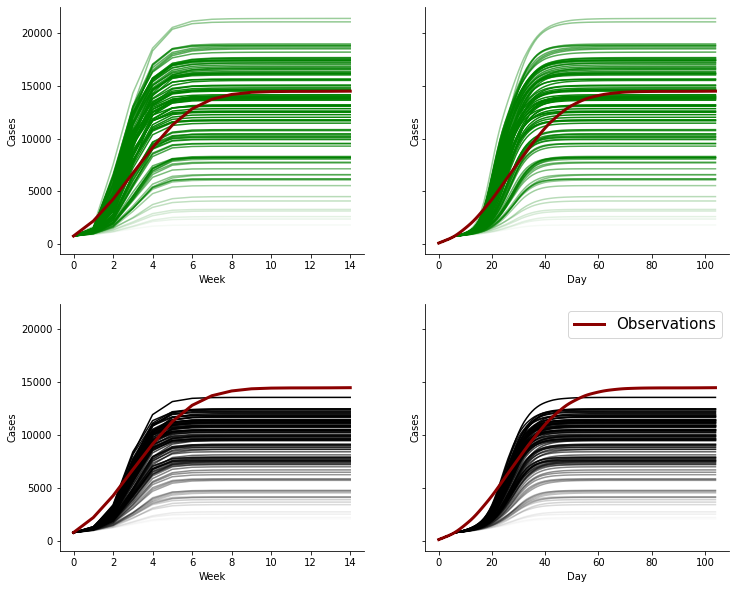

In [138]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(12,10),sharey= True)

########################################## Week 1

# Normalise distance to 0-1 to calculate transparency
_distance = np.array(windows_dict_new['w1']['distance'])  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
x = range(len(windows_dict_new['w1']['sim'][0]))
for i in range(len(windows_dict_new['w1']['summaries'])):
    ax1.plot(x, windows_dict_new['w1']['sim'][i],
            color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel("Week", size=10)
ax1.set_ylabel("Cases",size=10)

############# PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(windows_dict_new['w1']['summaries'][1])))
for i in range(len(windows_dict_new['w1']['summaries'])):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(windows_dict_new['w1']['summaries'][i]),
            color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
    
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel("Day", size=10)
ax2.set_ylabel("Cases",size=10)

########################################## Week 2

# Normalise distance to 0-1 to calculate transparency
_distance = np.array(windows_dict_new['w2']['distance'])  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
x = range(len(windows_dict_new['w2']['sim'][0]))
for i in range(len(windows_dict_new['w2']['summaries'])):
    ax3.plot(x, windows_dict_new['w2']['sim'][i],
            color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
# Plot observations
ax3.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_xlabel("Week", size=10)
ax3.set_ylabel("Cases",size=10)

############# PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(windows_dict_new['w2']['summaries'][1])))
for i in range(len(windows_dict_new['w2']['summaries'])):
    ax4.plot(x, OpenCLRunner.get_cumulative_new_infections(windows_dict_new['w2']['summaries'][i]),
            color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
    
# Plot observations
ax4.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax4.legend(fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=10)
ax4.set_xlabel("Day", size=10)
ax4.set_ylabel("Cases",size=10)

del _distance, distance_norm



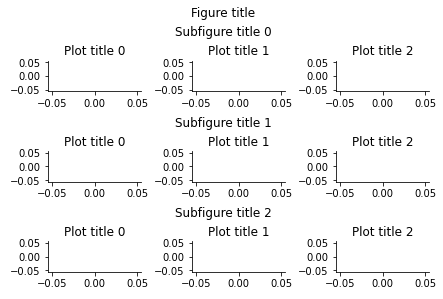

In [185]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True)
fig.suptitle('Figure title')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'Subfigure title {row}')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot()
        ax.set_title(f'Plot title {col}')

### Use parameters from dynamic calibration process to run model for 105 days - old method

In [190]:
# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30

# # Create dictionary to store results for each window
# windows_dict ={}

for window in ['w2']:

    # Define abc_history object from final window
    abc_history = history_dict[window]

    # Get dataframe of posterior parameter values
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

    # Sample from the dataframe of posteriors using KDE
    kde = MultivariateNormalTransition(scaling=1)
    kde.fit(df, w)
    samples = kde.rvs(N_samples)

    # Now run N models and store the results of each one
    distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

    negative_count = 0  # Count the number of negatives returned in the KDE posterior
    for i, sample in samples.iterrows():
        # Check for negatives. If needed, resample
        while (sample < 0).values.any():
            print("Found negatives. Resampling")
            negative_count += 1
            sample = kde.rvs()
            # Added in this line as the sample was in the wrong format for the while loop
            sample = pd.Series(sample)

        # Create a dictionary with the parameters and their values for this sample
        param_values = sample.to_dict()
        print(param_values)

        # _summaries = 
        (_distance, _sim, _obs, _out_params, _summaries) = \
            OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
        print(f"distance: {_distance}.")

        distance_l.append(_distance)
        sim_l.append(_sim)
        obs_l.append(_obs)
        out_params_l.append(_out_params)
        out_calibrated_params_l.append(param_values)
        summaries_l.append(_summaries)

    print(f"Finished sampling. Ignored {negative_count} negative samples.")

    # add to dictionary
    windows_dict[window] = {'distance': distance_l, 'sim': sim_l, 'obs':obs_l, 'summaries': summaries_l, 
                           'out_calibrated_params': out_calibrated_params_l, 'out_params': out_params_l}


Here
[ 2 40 94 18 92 82 51 97 37 52 82 79  6 75  2 37 39 79 40 31 20 69  3 83
 18 87 34 45 38 18]
{'asymptomatic': 0.2415327040209091, 'presymptomatic': 0.6836969951126947, 'primary_school': 0.4627438575724581, 'retail': 0.2068588570556729, 'secondary_school': 0.16148165737096692, 'symptomatic': 0.32738040972243937, 'work': 0.028089105839429532}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


distance: 42445.48822539919.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.1260148487633408, 'presymptomatic': 0.5334655112725357, 'primary_school': 0.042314932776405204, 'retail': 0.1612403428618121, 'secondary_school': 1.1904580003323402, 'symptomatic': 0.6219328605657899, 'work': 0.0144923796789026>
{'asymptomatic': 0.1260148487633408, 'presymptomatic': 0.5334655112725357, 'primary_school': 0.042314932776405204, 'retail': 0.1612403428618121, 'secondary_school': 1.1904580003323402, 'symptomatic': 0.6219328605657899, 'work': 0.0144923796789026}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42541.413510243714.
{'asymptomatic': 0.23346780901123404, 'presymptomatic': 0.3688237700467164, 'primary_school': 0.025988232252653832, 'retail': 0.48007019363718784, 'secondary_school': 0.24956636681192676, 'symptomatic': 0.2468062122265268, 'work': 0.02181979874789859}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.20s/it]


distance: 42574.29165193083.
{'asymptomatic': 0.277058070312139, 'presymptomatic': 0.28664683246107914, 'primary_school': 0.4230767412819748, 'retail': 0.14278041559791024, 'secondary_school': 0.13080297897016735, 'symptomatic': 0.3625117348767023, 'work': 0.05281634877738359}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


distance: 42217.74275021814.
{'asymptomatic': 0.16854706436749695, 'presymptomatic': 0.29584188023528235, 'primary_school': 1.0588533283883639, 'retail': 0.1874156658211702, 'secondary_school': 0.7913981831369269, 'symptomatic': 0.426407736571122, 'work': 0.03346755213604096}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42565.91497453938.
{'asymptomatic': 0.09620228468690452, 'presymptomatic': 0.7576936220206522, 'primary_school': 0.3246832060582275, 'retail': 0.15897563275035526, 'secondary_school': 1.2542312878350694, 'symptomatic': 0.5006879738961872, 'work': 0.016393159071643976}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42656.12840490837.
{'asymptomatic': 0.15327616745733674, 'presymptomatic': 0.8436479606915228, 'primary_school': 0.8666759355269362, 'retail': 0.2756212931770262, 'secondary_school': 0.6869345086091521, 'symptomatic': 0.07949330458945718, 'work': 0.01638300704233216}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42625.75577311027.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.16763560874808514, 'presymptomatic': 0.35682406527940325, 'primary_school': 0.6534930894220768, 'retail': 0.01807942447873981, 'secondary_school': 0.11066506366735862, 'symptomatic': 0.5066620279576317, 'work': 0.039166421226633163>
{'asymptomatic': 0.16763560874808514, 'presymptomatic': 0.35682406527940325, 'primary_school': 0.6534930894220768, 'retail': 0.01807942447873981, 'secondary_school': 0.11066506366735862, 'symptomatic': 0.5066620279576317, 'work': 0.039166421226633163}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


distance: 42707.832086707516.
{'asymptomatic': 0.2144842491587308, 'presymptomatic': 0.45096945822002754, 'primary_school': 0.01234733576451652, 'retail': 0.10300033006210546, 'secondary_school': 0.7810476697649194, 'symptomatic': 0.45958860961042686, 'work': 0.009897913774656845}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


distance: 42483.31472945087.
{'asymptomatic': 0.26251556791214814, 'presymptomatic': 0.12871800408346246, 'primary_school': 0.533849027534585, 'retail': 0.8145161640691445, 'secondary_school': 0.42127479942616197, 'symptomatic': 0.6038400001149761, 'work': 0.0004583991342064393}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42321.41253232632.
{'asymptomatic': 0.14119397765504174, 'presymptomatic': 0.6782174379666392, 'primary_school': 0.4960757486110022, 'retail': 0.055043443396809444, 'secondary_school': 1.3841398270825547, 'symptomatic': 0.5033491879950666, 'work': 0.044370029936181055}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


distance: 42381.51749570689.
Found negatives. Resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.1568406566074628, 'presymptomatic': 0.4149389793176726, 'primary_school': 0.09762043137892965, 'retail': 0.47628161353775944, 'secondary_school': 0.6649648725136909, 'symptomatic': 0.5370691740482706, 'work': 0.010018285240623787>
{'asymptomatic': 0.1568406566074628, 'presymptomatic': 0.4149389793176726, 'primary_school': 0.09762043137892965, 'retail': 0.47628161353775944, 'secondary_school': 0.6649648725136909, 'symptomatic': 0.5370691740482706, 'work': 0.010018285240623787}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


distance: 42624.63847544499.
{'asymptomatic': 0.2917873109386716, 'presymptomatic': 0.2997733974065793, 'primary_school': 0.4707447349748923, 'retail': 0.4797895859549467, 'secondary_school': 0.46002821554575934, 'symptomatic': 0.4212742376719356, 'work': 0.023093462494247725}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


distance: 42228.350368342464.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.239248416084706, 'presymptomatic': 0.8322969526811146, 'primary_school': 0.5090050682118697, 'retail': 0.20683487281601906, 'secondary_school': 0.2443021166841691, 'symptomatic': 0.46337051346716507, 'work': 0.07509364560603103>
{'asymptomatic': 0.239248416084706, 'presymptomatic': 0.8322969526811146, 'primary_school': 0.5090050682118697, 'retail': 0.20683487281601906, 'secondary_school': 0.2443021166841691, 'symptomatic': 0.46337051346716507, 'work': 0.07509364560603103}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.47s/it]


distance: 42243.0404517483.
Found negatives. Resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.18234826929222436, 'presymptomatic': 0.7760418049227892, 'primary_school': 0.29126316837411736, 'retail': 0.10131214357006257, 'secondary_school': 0.44027445366194645, 'symptomatic': 0.3398363789457414, 'work': 0.0404361666702034>
{'asymptomatic': 0.18234826929222436, 'presymptomatic': 0.7760418049227892, 'primary_school': 0.29126316837411736, 'retail': 0.10131214357006257, 'secondary_school': 0.44027445366194645, 'symptomatic': 0.3398363789457414, 'work': 0.0404361666702034}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


distance: 42562.228985337264.
Found negatives. Resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3122736843048316, 'presymptomatic': 0.2530517410009847, 'primary_school': 0.01710476669793834, 'retail': 0.2701828719103233, 'secondary_school': 0.2987239612402661, 'symptomatic': 0.357411874792759, 'work': 0.048057684960182784>
{'asymptomatic': 0.3122736843048316, 'presymptomatic': 0.2530517410009847, 'primary_school': 0.01710476669793834, 'retail': 0.2701828719103233, 'secondary_school': 0.2987239612402661, 'symptomatic': 0.357411874792759, 'work': 0.048057684960182784}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42150.020451598175.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.2735891582024451, 'presymptomatic': 0.2352756692081015, 'primary_school': 0.5403775162225719, 'retail': 0.9071045508522732, 'secondary_school': 0.661332739137066, 'symptomatic': 0.6707321246986321, 'work': 0.01053412077273013>
{'asymptomatic': 0.2735891582024451, 'presymptomatic': 0.2352756692081015, 'primary_school': 0.5403775162225719, 'retail': 0.9071045508522732, 'secondary_school': 0.661332739137066, 'symptomatic': 0.6707321246986321, 'work': 0.01053412077273013}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42243.63209665137.
Found negatives. Resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.13457389871444878, 'presymptomatic': 1.0212393686799608, 'primary_school': 0.5265915690755021, 'retail': 0.30294882424696545, 'secondary_school': 0.30349793947226594, 'symptomatic': 0.400701222679407, 'work': 0.0165759934642284>
{'asymptomatic': 0.13457389871444878, 'presymptomatic': 1.0212393686799608, 'primary_school': 0.5265915690755021, 'retail': 0.30294882424696545, 'secondary_school': 0.30349793947226594, 'symptomatic': 0.400701222679407, 'work': 0.0165759934642284}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


distance: 42666.71047338037.
{'asymptomatic': 0.2442805435636642, 'presymptomatic': 0.37382639937894846, 'primary_school': 0.3450411642747222, 'retail': 0.21369569177153008, 'secondary_school': 0.7561325420528647, 'symptomatic': 0.3460066408374313, 'work': 0.017041937090100576}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


distance: 42291.68326775232.
Found negatives. Resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.3006510685994475, 'presymptomatic': 0.3684414278377955, 'primary_school': 0.32635535265168697, 'retail': 0.41159408000150066, 'secondary_school': 0.07201556180643243, 'symptomatic': 0.5921561695334475, 'work': 0.013526212292656926>
{'asymptomatic': 0.3006510685994475, 'presymptomatic': 0.3684414278377955, 'primary_school': 0.32635535265168697, 'retail': 0.41159408000150066, 'secondary_school': 0.07201556180643243, 'symptomatic': 0.5921561695334475, 'work': 0.013526212292656926}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


distance: 42183.51123878679.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.20939239074545568, 'presymptomatic': 0.3462347389757113, 'primary_school': 0.41882828465006855, 'retail': 0.6064248399706615, 'secondary_school': 0.40402789341720385, 'symptomatic': 0.4041711614497098, 'work': 0.026965067763127844>
{'asymptomatic': 0.20939239074545568, 'presymptomatic': 0.3462347389757113, 'primary_school': 0.41882828465006855, 'retail': 0.6064248399706615, 'secondary_school': 0.40402789341720385, 'symptomatic': 0.4041711614497098, 'work': 0.026965067763127844}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.50s/it]


distance: 42580.51478203161.
Found negatives. Resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.20702728035330986, 'presymptomatic': 0.4337821956251665, 'primary_school': 0.4523093558889, 'retail': 0.08404564163567094, 'secondary_school': 0.3882980344179489, 'symptomatic': 0.3742310546814032, 'work': 0.028733458438454616>
{'asymptomatic': 0.20702728035330986, 'presymptomatic': 0.4337821956251665, 'primary_school': 0.4523093558889, 'retail': 0.08404564163567094, 'secondary_school': 0.3882980344179489, 'symptomatic': 0.3742310546814032, 'work': 0.028733458438454616}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.16s/it]


distance: 42529.68587347365.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.2648151671159736, 'presymptomatic': 0.21997013484206457, 'primary_school': 0.5945632961103475, 'retail': 0.18052560822748354, 'secondary_school': 0.10385764915951273, 'symptomatic': 0.3766625743582159, 'work': 0.0829757374656589>
{'asymptomatic': 0.2648151671159736, 'presymptomatic': 0.21997013484206457, 'primary_school': 0.5945632961103475, 'retail': 0.18052560822748354, 'secondary_school': 0.10385764915951273, 'symptomatic': 0.3766625743582159, 'work': 0.0829757374656589}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


distance: 42194.40572849935.
Found negatives. Resampling
Negatives: resampling
Negatives: resampling
Negatives: resampling
Perturbed parameter <Parameter 'asymptomatic': 0.22351880259892998, 'presymptomatic': 0.5826739033276853, 'primary_school': 0.5445918037272043, 'retail': 0.16711078749695224, 'secondary_school': 0.35319982467507993, 'symptomatic': 0.5490946199206408, 'work': 0.015647839925024686>
{'asymptomatic': 0.22351880259892998, 'presymptomatic': 0.5826739033276853, 'primary_school': 0.5445918037272043, 'retail': 0.16711078749695224, 'secondary_school': 0.35319982467507993, 'symptomatic': 0.5490946199206408, 'work': 0.015647839925024686}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 42550.33477002834.
{'asymptomatic': 0.22367103841306007, 'presymptomatic': 0.5185439201411048, 'primary_school': 0.13201209269218583, 'retail': 0.09733369647080445, 'secondary_school': 0.5276089530362392, 'symptomatic': 0.5481219147631355, 'work': 0.06041602949388661}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


distance: 42307.5111620686.
{'asymptomatic': 0.24066548718091657, 'presymptomatic': 0.499742407658008, 'primary_school': 0.48162818918016337, 'retail': 0.6033835745592611, 'secondary_school': 7.268772369081744e-05, 'symptomatic': 0.4564476753807685, 'work': 0.009218354957589965}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


distance: 42529.440902628994.
{'asymptomatic': 0.35007484097891006, 'presymptomatic': 0.033568277527507184, 'primary_school': 0.4572571850363827, 'retail': 0.2839794172230896, 'secondary_school': 0.16149458010463083, 'symptomatic': 0.409337390539394, 'work': 0.11091892610555665}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


distance: 41897.263448796795.
{'asymptomatic': 0.23275431921694556, 'presymptomatic': 0.5112291681987616, 'primary_school': 0.3873984900886953, 'retail': 0.004698905654403729, 'secondary_school': 0.5126367058756575, 'symptomatic': 0.2909281336789466, 'work': 0.029882966480077468}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.60s/it]


distance: 42440.67343448264.
Found negatives. Resampling
Perturbed parameter <Parameter 'asymptomatic': 0.14100597598880696, 'presymptomatic': 0.4564490472063324, 'primary_school': 0.8906311853919288, 'retail': 0.361613741580653, 'secondary_school': 0.1957334392209072, 'symptomatic': 0.5193967314012147, 'work': 0.0508783557032934>
{'asymptomatic': 0.14100597598880696, 'presymptomatic': 0.4564490472063324, 'primary_school': 0.8906311853919288, 'retail': 0.361613741580653, 'secondary_school': 0.1957334392209072, 'symptomatic': 0.5193967314012147, 'work': 0.0508783557032934}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]


distance: 42682.67947634118.
{'asymptomatic': 0.290561593527605, 'presymptomatic': 0.388999895684532, 'primary_school': 0.35844381444363604, 'retail': 0.2246192020564133, 'secondary_school': 0.3864069046603508, 'symptomatic': 0.5321957081447712, 'work': 0.044860804809047854}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.32s/it]

distance: 42249.3128454718.
Finished sampling. Ignored 14 negative samples.


#### Plot the individual results for each sample and compare to observations

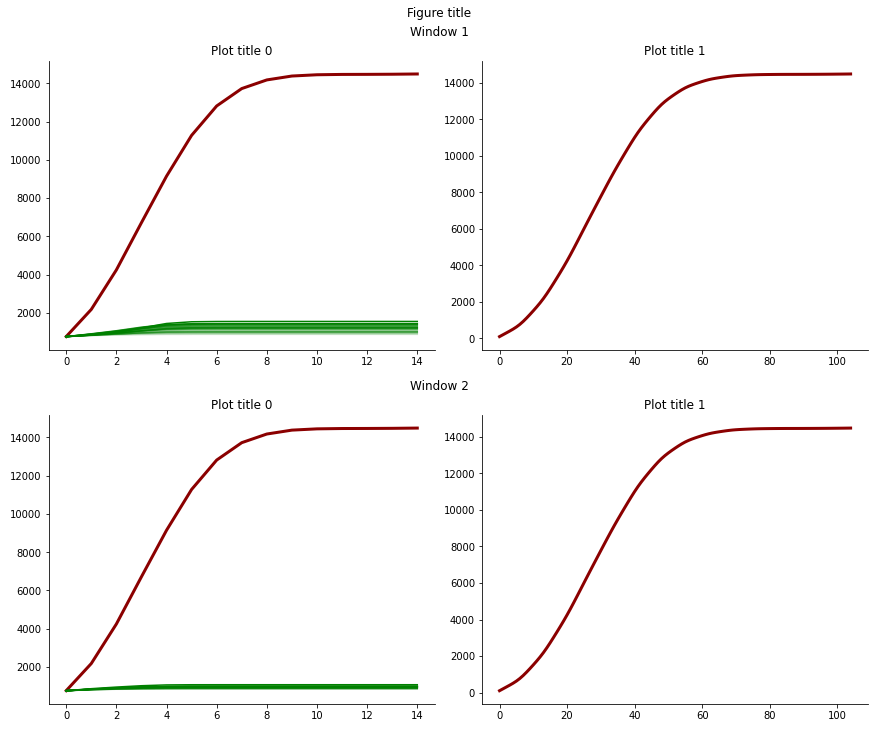

In [205]:
windows= ['w1','w2']

# create 3x1 subplots
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize = (12,10))
fig.suptitle('Figure title')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

windows_i = 0
for row, subfig in enumerate(subfigs):
    subfig.suptitle('Window {}'.format(row+1))
    this_windows_dict = windows_dict[windows[windows_i]]
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        
        # Plot model values
        _distance = np.array(this_windows_dict['distance'])  # Easier to do maths on np.array
        distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
        # Plot observations
        if col == 0:
            x = range(len(windows_dict['w1']['sim'][0]))
            ax.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
            for i in range(len(this_windows_dict['summaries'])):
                ax.plot(x, this_windows_dict['sim'][i],
                color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
        elif col ==1:
            x = range(len(OpenCLRunner.get_cumulative_new_infections(windows_dict['w1']['summaries'][1])))
            ax.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
            for i in range(len(windows_dict['w1']['summaries'])):
                ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(windows_dict['w1']['summaries'][i]),
                color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
            
        ax.set_title(f'Plot title {col}')
    
    # move on to next window
    windows_i = windows_i+1

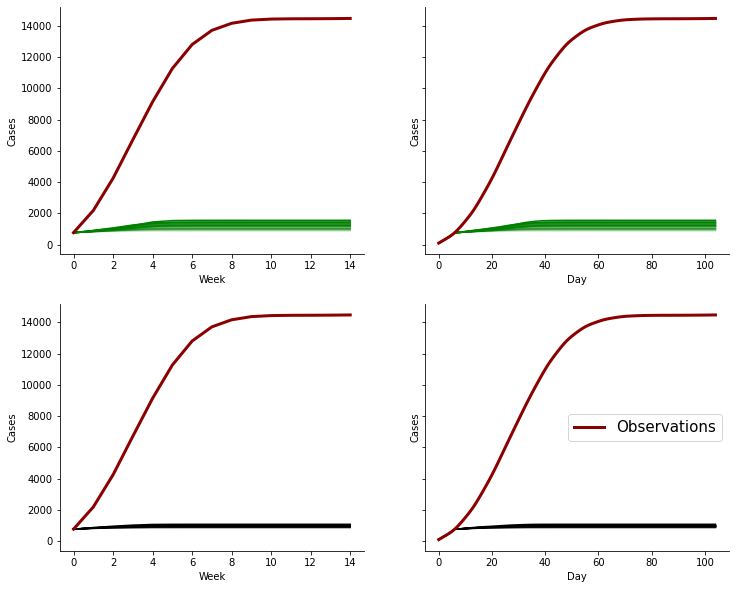

In [206]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(12,10),sharey= True)

########################################## Week 1

# Normalise distance to 0-1 to calculate transparency
_distance = np.array(windows_dict['w1']['distance'])  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
x = range(len(windows_dict['w1']['sim'][0]))
for i in range(len(windows_dict['w1']['summaries'])):
    ax1.plot(x, windows_dict['w1']['sim'][i],
            color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel("Week", size=10)
ax1.set_ylabel("Cases",size=10)

############# PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(windows_dict['w1']['summaries'][1])))
for i in range(len(windows_dict['w1']['summaries'])):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(windows_dict['w1']['summaries'][i]),
            color="green", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
    
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_xlabel("Day", size=10)
ax2.set_ylabel("Cases",size=10)

########################################## Week 2

# Normalise distance to 0-1 to calculate transparency
_distance = np.array(windows_dict['w2']['distance'])  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
x = range(len(windows_dict['w2']['sim'][0]))
for i in range(len(windows_dict['w2']['summaries'])):
    ax3.plot(x, windows_dict['w2']['sim'][i],
            color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
# Plot observations
ax3.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_xlabel("Week", size=10)
ax3.set_ylabel("Cases",size=10)

############# PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(windows_dict['w2']['summaries'][1])))
for i in range(len(windows_dict['w2']['summaries'])):
    ax4.plot(x, OpenCLRunner.get_cumulative_new_infections(windows_dict['w2']['summaries'][i]),
            color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
    
# Plot observations
ax4.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax4.legend(fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=10)
ax4.set_xlabel("Day", size=10)
ax4.set_ylabel("Cases",size=10)

del _distance, distance_norm



### Run model with single 'best' estimate of parameter values 

#### Find the sample drawn from the posterior distribution which has the smallest distance (best performing!)

In [156]:
# Find the index of the lowest distance value
best_model_idx = np.argmin(distance_l)
# Find the corresponding parameter values
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'asymptomatic': 0.2734354873840715, 'presymptomatic': 0.05621702154625283, 'primary_school': 0.5443011438298013, 'retail': 0.1803249305641282, 'secondary_school': 0.13885818621576718, 'symptomatic': 0.7236784487100028, 'work': 0.01519919545619513}


#### See how the parameters from the particle with the lowest distance relate to the marginal posteriors

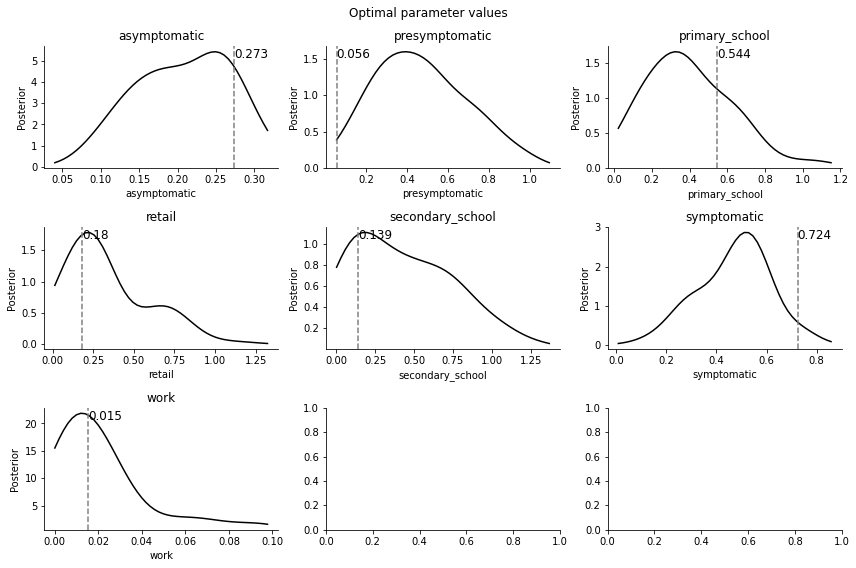

In [157]:
fig, axes = plt.subplots(3,3, figsize=(12,8))
abc_history = history_dict['w2']
for i, param in enumerate(best_params.keys()):
    ax = axes.flat[i]
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/abc_history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None) # Make the last one black
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

#### Run model with 'best' parameter values

In [163]:
# Initialise the class so that its ready to run the model.
OpenCLRunner.init(
    iterations = 105,  repetitions = 5,observations = cases_devon_weekly, use_healthier_pop = True, 
    use_gpu = True, store_detailed_counts = False, parameters_file = PARAMETERS_FILE,opencl_dir = OPENCL_DIR,
    snapshot_filepath = SNAPSHOT_FILEPATH,num_seed_days = 7) 
OpenCLRunner.set_constants(const_params_dict)

# Run
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bestparams, sim_bestparams, obs_bestparams, out_params_bestparams, summaries_bestparams) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


{'w1': {'distance': [41474.214016081954, 42684.042497162154, 41380.590954881125, 41281.89837990867, 42226.433482253255, 42091.988726870935, 41686.199455845795, 40675.83372577044, 41496.95208219043, 40336.66778519044, 41620.664761789485, 42531.13934378397, 42355.10638619746, 42059.6608283148, 40762.890658096425, 41105.109158406965, 41891.984781487656, 40935.111436797546, 42545.40143045185, 42545.98061930972, 40734.699019648215, 42090.30204854082, 42413.88663397764, 42147.583420153336, 42615.18474342259, 42674.76724020041, 42284.56224071141, 42663.9199643789, 41399.61314520997, 42156.49558978193], 'sim': [array([ 766. ,  854.6,  952.6, 1072.2, 1166.6, 1201.6, 1208.8, 1210.4,
       1210.4, 1210.4, 1210.4, 1210.4, 1210.4, 1210.4, 1210.4]), array([766. , 811.4, 836.2, 844.8, 847. , 847. , 847. , 847. , 847. ,
       847. , 847. , 847. , 847. , 847. , 847. ]), array([ 766. ,  846. ,  947.2, 1070.2, 1192.6, 1232. , 1238.8, 1239.4,
       1239.6, 1239.6, 1239.6, 1239.6, 1239.6, 1239.6, 1239.6

{'w1': {'distance': [41701.76607750886, 41485.969290732945, 42011.88141398746, 42630.64703470185, 41872.638703324, 42084.46172869783, 42803.636383219964, 42329.74003782856, 41748.490180730994, 42421.44092082667, 42616.15409859739, 42835.23967462838, 42609.14042975221, 39628.05412605671, 42416.95852431173, 41472.67908488661, 41596.64868670596, 42745.37128128238, 40464.1085279999, 41429.12696747434, 42702.373387661704, 42519.7387951169, 42037.06584919358, 42610.82536615994, 41931.2532674831, 42181.13654318483, 42068.0773759907, 42585.917927672075, 42848.229855330756, 42389.27472548092, 42286.175283296194, 42220.76310461558, 41399.936396695295, 42652.39825980785, 41836.94422358882, 42224.87260809632, 41968.07258664854, 42282.71497250245, 42767.21112368377, 41803.39529752044, 41423.33328154992, 42689.99529431875, 42647.38410640326, 42634.150104768596, 41789.216031551565, 42704.439268849266, 42662.70895610313, 42262.95965574324, 42030.19330143567, 41665.19727082341, 42011.62421653907, 42199

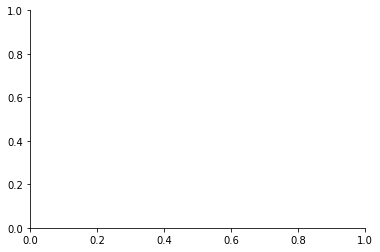

In [191]:
# Check the model returns the observations correctly (should be same as initial, default model)
# np.array_equal(obs0, obs1)
fig, ax = plt.subplots(1,1)
x = range(len(sim_bestparams))
for my_dict, window in zip([windows_dict, windows_dict_new, windows_dict, windows_dict_new],['w1','w2', 'w1', 'w2']):
        print(my_dict, window)
        # Find the index of the lowest distance value
        best_model_idx = np.argmin(my_dict[window]['distance'])
        # Find the corresponding parameter values
        best_params = my_dict[window]['out_calibrated_params'][best_model_idx]

# ax.plot(x, sim_bestparams, label="best_params", color="red")
# ax.plot(x, sim_manualcalibration, label="manual_calibration", color="green")
# # Add distance text
# # for a, b in [(summaries_manualcalibration,distance_manualcalibration), (summaries_bestparams, distance_bestparams)]:
# #     ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
# ax.plot(x, initial_cases_weekly['CumulativeCases'][0:(int(ITERATIONS/7))], label="obs", color="blue")
# ax.legend()
# print(f"distance: {distance_bestparams2}")




In [161]:
# # ### Initialise the ABC algorithm.
# abc = pyabc.ABCSMC(
#     models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
#     parameter_priors=priors, # Priors (could be a list)
#     distance_function=OpenCLWrapper.dummy_distance,  # Distance function
#     # distance_function = OpenCLWrapper.distance,
#     sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
#     #transition=transition,  # Define how to transition from one population to the next
#     )

#### Plot results

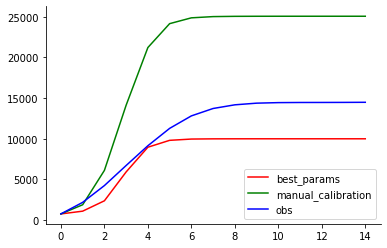

In [178]:
sim_bestparams

# Check the model returns the observations correctly (should be same as initial, default model)
# np.array_equal(obs0, obs1)
fig, ax = plt.subplots(1,1)
x = range(len(sim_bestparams))
ax.plot(x, sim_bestparams, label="best_params", color="red")
ax.plot(x, sim_manualcalibration, label="manual_calibration", color="green")
# Add distance text
# for a, b in [(summaries_manualcalibration,distance_manualcalibration), (summaries_bestparams, distance_bestparams)]:
#     ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, initial_cases_weekly['CumulativeCases'][0:(int(ITERATIONS/7))], label="obs", color="blue")
ax.legend()


Text(0, 0.5, 'Cases')

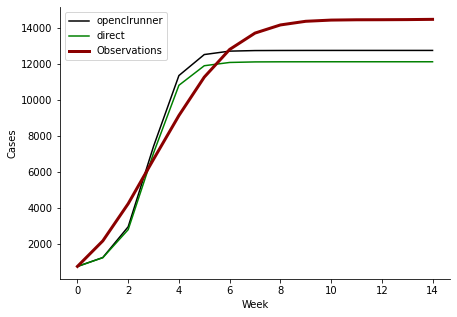

In [135]:
fig, ax = plt.subplots(figsize = (7,5))
x = range(len(sim_l[0]))
ax.plot(x, sim_l[best_model_idx],color="black", label = 'openclrunner') # (1-x because high distance is bad)
ax.plot(x, sim_bestparams, label="direct", color="green")
# Plot observations
ax.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")

# Plot result from manually calibrated model
ax.legend(fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel("Week", size=10)
ax.set_ylabel("Cases",size=10)

### Compare spatial distribution

Can't do this currently as OpenCLRunner doesn't return a breakdown by MSOA

### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)